In [16]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import torch as t
from utils.config import opt
from model import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
from data.util import  read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
import numpy as np
import pickle
import matplotlib.pyplot as plt


%matplotlib inline

TRAIN_MODE = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

# Load model trained with caffe pretrained model

In [18]:
%ls checkpoints/

7class/                                 fasterrcnn_04151958_0.7435728692746989
cars/                                   fasterrcnn_04152043_0.7459420675485349
cars_vans/                              fasterrcnn_04152235_0.7462277363985176
fasterrcnn_04151829_0.6704369972064141  vgg16_caffe.pth
fasterrcnn_04151851_0.6877679369254311  VOC_weights/
fasterrcnn_04151914_0.7164561623943497


In [19]:
trainer.load('./checkpoints/fasterrcnn_04152235_0.7462277363985176')

FasterRCNNTrainer(
  (faster_rcnn): FasterRCNNVGG16(
    (extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): MaxPoo

In [20]:
img = read_image('misc/demo.jpg')
img = t.from_numpy(img)[None]

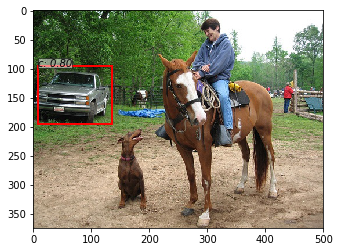

In [21]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=True)

vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

# Display a Kitti image

In [22]:
import os

dataset_dir = '/media/tadenoud/DATADisk/datasets/kitti_2d'  # School comp
# dataset_dir = '/home/tadenoud/Documents/kitti' # Laptop

img_paths = [
    os.path.join(dataset_dir, 'training/image_2/005009.png'),
    os.path.join(dataset_dir, 'training/image_2/005010.png')
]

imgs = np.array([read_image(p) for p in img_paths])

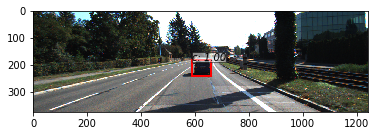

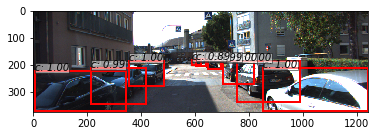

In [23]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(imgs,visualize=True)
vis_bbox(at.tonumpy(imgs[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

vis_bbox(at.tonumpy(imgs[1]),
         at.tonumpy(_bboxes[1]),
         at.tonumpy(_labels[1]).reshape(-1),
         at.tonumpy(_scores[1]).reshape(-1))

In [24]:
# Read a Kitti GT label
from data.util import read_bbox

img_label_paths = [
    os.path.join(dataset_dir, 'training/label_2/005009.txt'),
    os.path.join(dataset_dir, 'training/label_2/005010.txt')
]

gt = np.array([read_bbox(p, ignore_dontcare=True, ignore_missing_labels=True) for p in img_label_paths]) 
gt_bboxes = gt[:,0]
gt_labels = gt[:,1]

scales = np.array([[im.shape[2] / im.shape[1]] for im in imgs])

# Train mahalanobis features with entire training dataset

In [25]:
from utils.config import opt
from data.dataset import Dataset, TestDataset
from torch.utils.data import DataLoader

print('load data')

opt.voc_data_dir = "/media/tadenoud/DATADisk/datasets/kitti_2d/VOC2012/"
dataset = Dataset(opt)
dataloader = DataLoader(dataset,
                        batch_size=1,
                        shuffle=False,
                        pin_memory=True,
                        num_workers=opt.num_workers)

if TRAIN_MODE:
    mahal_means, mahal_cov = trainer.faster_rcnn.train_ood(dataloader)

    with open('kitti_features.pickle', 'wb') as f:
        pickle.dump(trainer.faster_rcnn.features, f)

    with open('mahal_means.pickle', 'wb') as f:
        pickle.dump(mahal_means, f)

    with open('mahal_cov.pickle', 'wb') as f:
        pickle.dump(mahal_cov, f)

    with open('inv_mahal_cov.pickle', 'wb') as f:
        pickle.dump(trainer.faster_rcnn.inv_mahal_cov, f)

else:
    with open('kitti_features.pickle', 'rb') as f:
        trainer.faster_rcnn.features = pickle.load(f)

    with open('mahal_means.pickle', 'rb') as f:
        mahal_means = pickle.load(f)
        trainer.faster_rcnn.mahal_means = mahal_means

    with open('mahal_cov.pickle', 'rb') as f:
        mahal_cov = pickle.load(f)
        trainer.faster_rcnn.mahal_cov = mahal_cov

    with open('inv_mahal_cov.pickle', 'rb') as f:
        inv_mahal_cov = pickle.load(f)
        trainer.faster_rcnn.inv_mahal_cov = inv_mahal_cov

load data


In [26]:
from tqdm import tqdm

if TRAIN_MODE:
    with open('gt_labels.pickle', 'wb') as f:
        pickle.dump(trainer.faster_rcnn.gt_labels, f)
# else:
    
with open('gt_labels.pickle', 'rb') as f:
    gt_labels = pickle.load(f)

In [27]:
VOC_BBOX_LABEL_NAMES = (
    'car',
    'van',
    'truck',
    'tram',
    'person',
    'person_sitting',
    'cyclist',
    'misc'
    # 'dontcare
)

for j in range(8):
    print(VOC_BBOX_LABEL_NAMES[j], "count:", sum([i == j for i in gt_labels]))

car count: 2620
van count: 0
truck count: 0
tram count: 0
person count: 0
person_sitting count: 0
cyclist count: 0
misc count: 0


# Visualize features using t-SNE

In [28]:
from time import time
from sklearn.manifold import TSNE

if TRAIN_MODE:
    print("Computing t-SNE embedding")
    tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=20)
    t0 = time()
    X_tsne = tsne.fit_transform(trainer.faster_rcnn.features)
    t1 = time()
    
    with open("tsne_features.pickle", "wb") as f:
        pickle.dump(X_tsne, f)

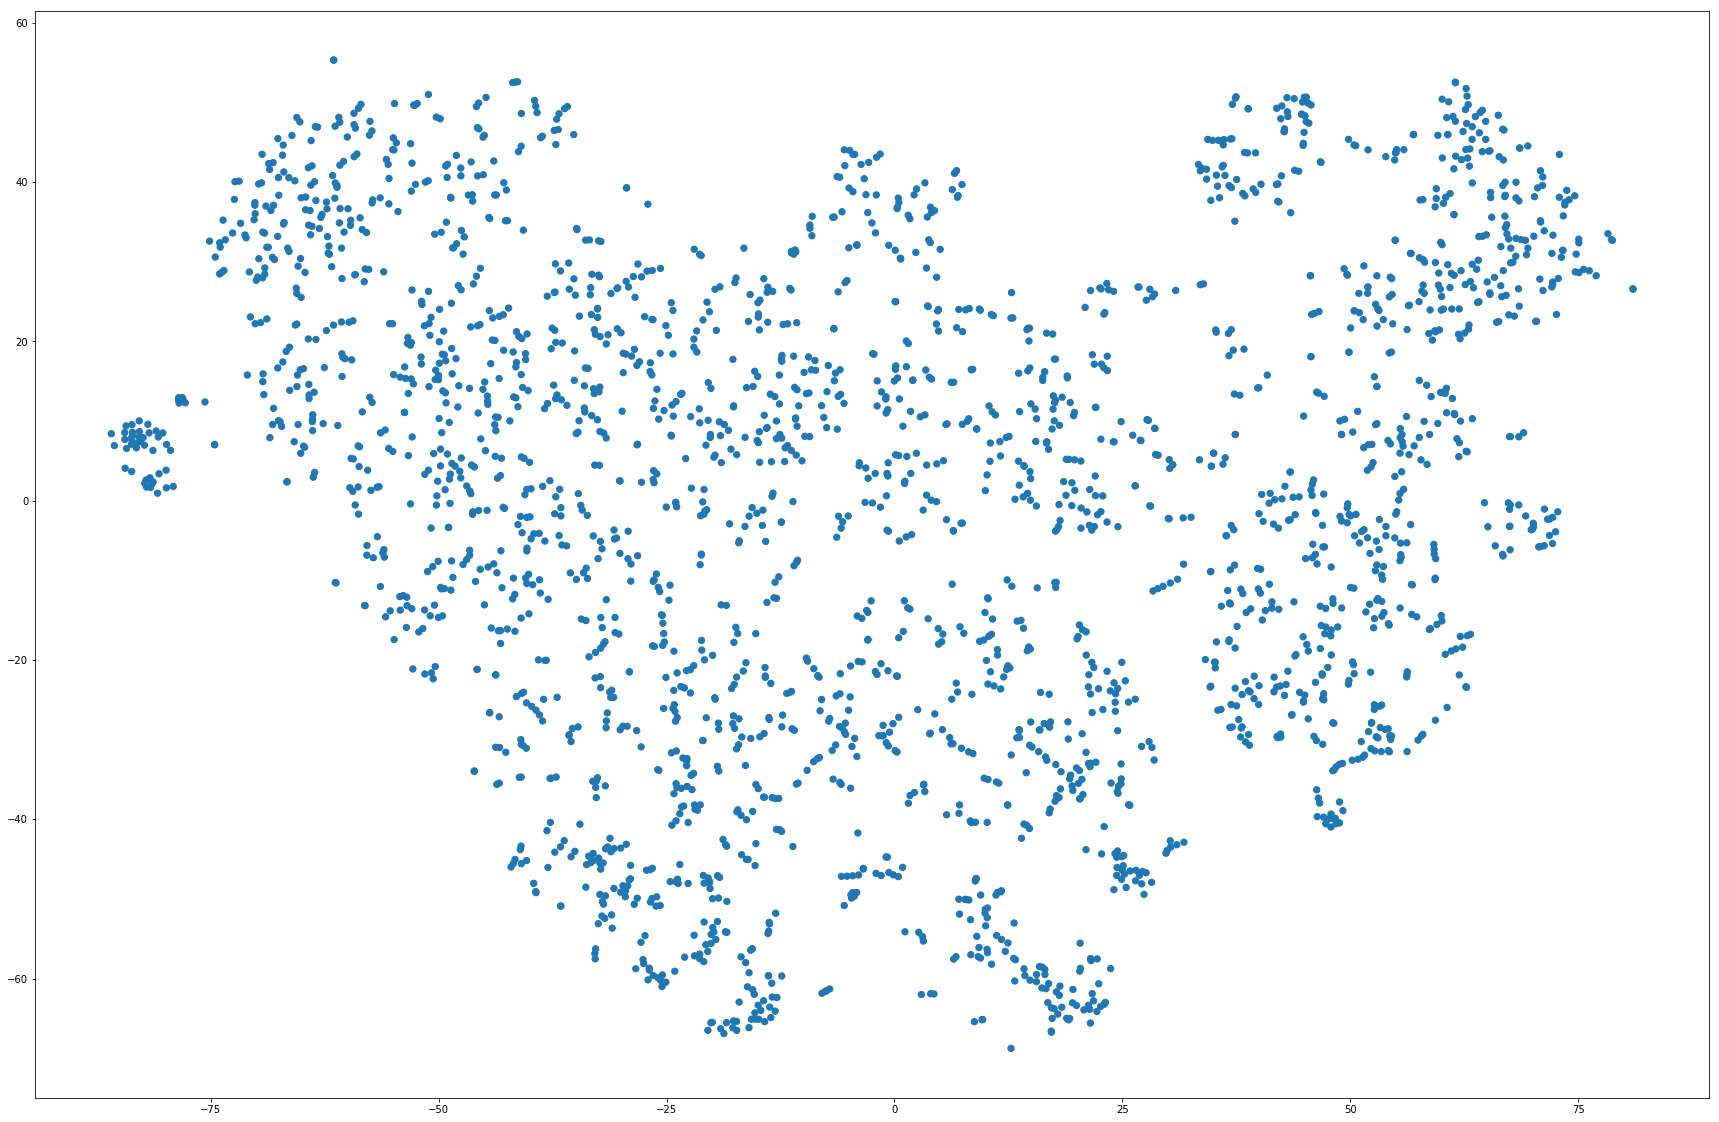

In [29]:
import matplotlib.pyplot as plt

with open("tsne_features.pickle", "rb") as f:
    X_tsne = pickle.load(f)

mask = (gt_labels != -1)
plt.figure(figsize=(30, 20))
plt.scatter(X_tsne[:,0][mask], X_tsne[:,1][mask], c=gt_labels[mask], s=40, cmap=plt.cm.get_cmap('tab10'))
plt.show()

# Predict class using features

In [31]:
# Evaluate baseline softmax method
from train import eval, eval_mahal

print('load data') 
test_dataset = TestDataset(opt)
test_dataloader = DataLoader(test_dataset,
                             batch_size=1,
                             shuffle=False,
                             pin_memory=True,
                             num_workers=opt.num_workers)

if TRAIN_MODE:
    baseline_result = eval(test_dataloader, trainer.faster_rcnn, test_num=opt.test_num)
    with open("baseline_results.pickle", 'wb') as f:
        pickle.dump(baseline_result, f)
    
with open("baseline_results.pickle", 'rb') as f:
    baseline_result = pickle.load(f)
    
print(baseline_result)

load data
{'map': 0.7462277363985176, 'ap': array([0.74622774])}


In [32]:
# Evaluate mahalanobis distance method

if TRAIN_MODE:
    mahal_result = eval_mahal(test_dataloader, trainer.faster_rcnn, test_num=opt.test_num)
    with open("mahal_result.pickle", "wb") as f:
        pickle.dump(mahal_result, f)
else:    
    with open("mahal_result.pickle", "rb") as f:
        mahal_result = pickle.load(f)
    
print(mahal_result)



{'map': 0.7134610450402596, 'ap': array([0.71346105])}


[[ 95.70908     7.0471992 195.97632   134.77736  ]]
[0]
[77.333984]


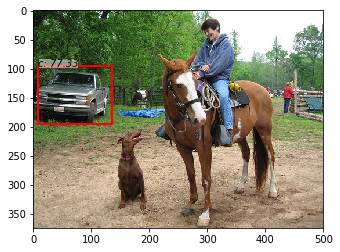

In [33]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict_mahalanobis(img,visualize=True)

print(_bboxes[0])
print(_labels[0])
print(_scores[0])

vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0].reshape(-1)),
         at.tonumpy(_scores[0].reshape(-1)))

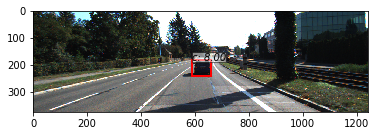

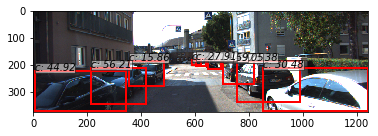

In [34]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict_mahalanobis(imgs,visualize=True)
vis_bbox(at.tonumpy(imgs[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

vis_bbox(at.tonumpy(imgs[1]),
         at.tonumpy(_bboxes[1]),
         at.tonumpy(_labels[1]).reshape(-1),
         at.tonumpy(_scores[1]).reshape(-1))

# Do some predictions of "weird car" images from Google

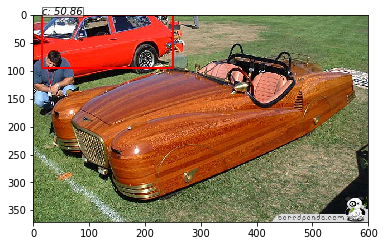

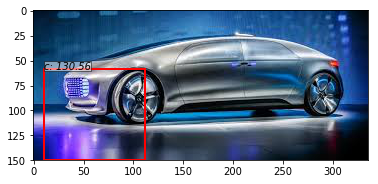

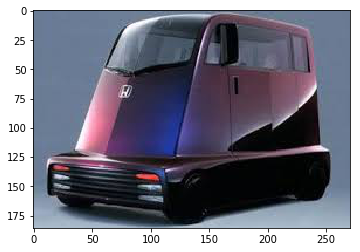

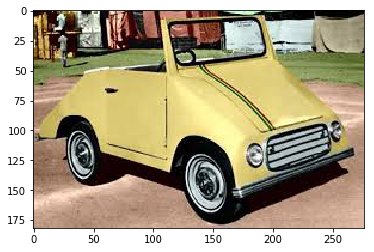

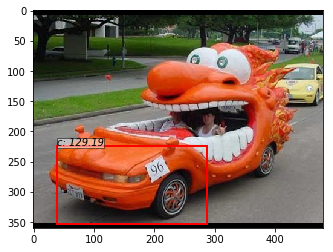

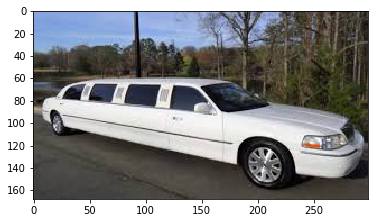

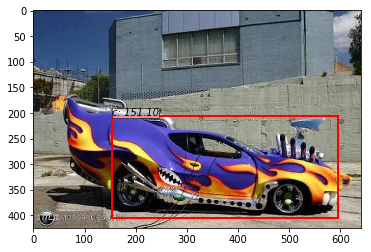

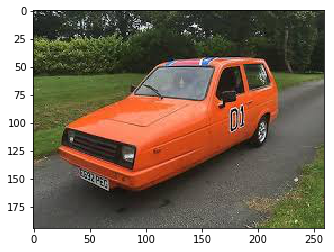

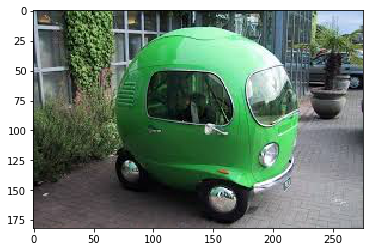

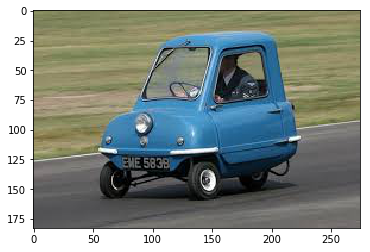

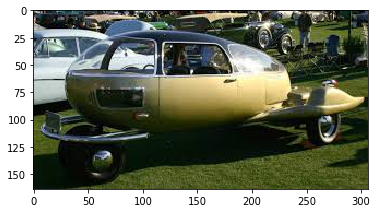

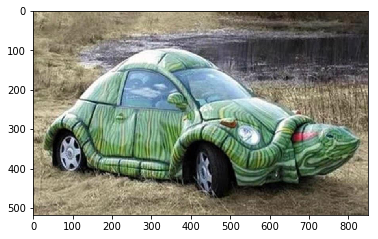

In [35]:
for img_name in os.listdir("./weird_cars"):
    img_path = os.path.join("./weird_cars", img_name)
    im = np.array(read_image(img_path))
    
    _bboxes, _labels, _scores = trainer.faster_rcnn.predict_mahalanobis([im], visualize=True)
    
    vis_bbox(at.tonumpy(im),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

# AUROC Mahalanobis on test data

In [36]:
opt.voc_data_dir = "/media/tadenoud/DATADisk/datasets/kitti_2d/VOC2012/"
dataset = TestDataset(opt)
dataloader = DataLoader(dataset,
                        batch_size=1,
                        shuffle=False,
                        pin_memory=True,
                        num_workers=opt.num_workers)

In [37]:
if TRAIN_MODE:
    features = []
    gt_labels = []

    pred_bboxes, pred_labels, pred_scores = list(), list(), list()
    gt_bboxes, gt_labels, gt_difficults = list(), list(), list()
    for ii, (imgs, sizes, gt_bboxes_, gt_labels_, gt_difficults_) in tqdm(enumerate(dataloader), total=opt.test_num):
        sizes = [sizes[0][0].item(), sizes[1][0].item()]
        pred_bboxes_, pred_labels_, pred_scores_ = faster_rcnn.predict_mahalanobis(imgs, [sizes])
        gt_bboxes += list(gt_bboxes_.numpy())
        gt_labels += list(gt_labels_.numpy())
        gt_difficults += list(gt_difficults_.numpy())
        pred_bboxes += pred_bboxes_
        pred_labels += pred_labels_
        pred_scores += pred_scores_
        
    with open("gt_bboxes_test.pickle", "wb") as f:
        pickle.dump(gt_bboxes, f)
    with open("gt_labels_test.pickle", "wb") as f:
        pickle.dump(gt_labels, f)
    with open("gt_difficults_test.pickle", "wb") as f:
        pickle.dump(gt_difficults, f)

    with open("pred_bboxes_test.pickle", "wb") as f:
        pickle.dump(pred_bboxes, f)
    with open("pred_labels_test.pickle", "wb") as f:
        pickle.dump(pred_labels, f)
    with open("pred_scores_test.pickle", "wb") as f:
        pickle.dump(pred_scores, f)

else:
    with open("gt_bboxes_test.pickle", "rb") as f:
        gt_bboxes= pickle.load(f)
    with open("gt_labels_test.pickle", "rb") as f:
        gt_labels = pickle.load(f)
    with open("gt_difficults_test.pickle", "rb") as f:
        gt_difficults = pickle.load(f)

    with open("pred_bboxes_test.pickle", "rb") as f:
        pred_bboxes = pickle.load(f)
    with open("pred_labels_test.pickle", "rb") as f:
        pred_labels = pickle.load(f)
    with open("pred_scores_test.pickle", "rb") as f:
        pred_scores = pickle.load(f)

In [38]:
from model.utils.bbox_tools import bbox_iou

def iou(bbox, label, gt_boxes, gt_labels):
    ious = [bbox_iou(np.array([bbox]), np.array([gt_b])) for gt_b in gt_boxes]
    max_iou = np.max(ious)
    
    if max_iou > 0:
        return max_iou, gt_labels[np.argmax(ious)] == label
    return 0., False

In [39]:
# Ground truth bboxes
print("Ground truth bboxes:", len(np.concatenate(gt_bboxes)))

# Pred bboxes
print("Pred bboxes:", len(np.concatenate(pred_bboxes)))

IOU_THRESH = 0.5

# Loop through results by image
overlapping_bboxes = list()
correct_classification = list()

for ii, (gt_bbox, gt_label, pred_bbox, pred_label, pred_score) \
            in enumerate(zip(gt_bboxes, gt_labels, pred_bboxes, pred_labels, pred_scores)):
    # Calculate if the pred bbox has an overlapping gt_bbox
    overlapping_bboxes.append([])
    correct_classification.append([])
    for bbox, label, score in zip(pred_bbox, pred_label, pred_score):
        overlapping_bbox, correct_class = iou(bbox, label, gt_bbox, gt_label)
        overlapping_bboxes[-1].append(overlapping_bbox >= IOU_THRESH)
        correct_classification[-1].append(correct_class)

Ground truth bboxes: 20281
Pred bboxes: 20642


In [40]:
from itertools import chain
from metrics import barcode_plot, fpr_at_95_tpr, auroc, detection_error

scores = [-1 * s for s in chain(*pred_scores)]
overlap_correct = list(chain(*overlapping_bboxes))
class_correct = list(chain(*correct_classification))
both_correct = [a and b for a, b in zip(overlap_correct, class_correct)]

print("AUROC")
print("Overlap", auroc(scores, overlap_correct))
print("Class", auroc(scores, class_correct))
print("Both", auroc(scores, both_correct))
print()
print("FPR@95TPR")
print("Overlap", fpr_at_95_tpr(scores, overlap_correct))
print("Class", fpr_at_95_tpr(scores, class_correct))
print("Both", fpr_at_95_tpr(scores, both_correct))
print()
print("Detection Err")
print("Overlap", detection_error(scores, overlap_correct))
print("Class", detection_error(scores, class_correct))
print("Both", detection_error(scores, both_correct))

AUROC
Overlap 0.8798998295694807
Class 0.7632292733382243
Both 0.8875865844209708

FPR@95TPR
Overlap 0.49336183618361834
Class 0.8267229254571027
Both 0.4370482252670191

Detection Err
Overlap 0.2716511409946507
Class 0.4382926970002199
Both 0.24349553618050682


In [41]:
print("Correctly classified {:.3f}%".format(sum([int(a) for a in class_correct]) /  len(class_correct) * 100))
print("Correctly bboxes {:.3f}%".format(sum([int(a) for a in overlap_correct]) /  len(overlap_correct) * 100))

Correctly classified 82.778%
Correctly bboxes 56.942%


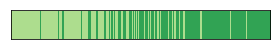

In [42]:
from metrics import barcode_plot, fpr_at_95_tpr, auroc
barcode_plot(scores, both_correct)

# AUROC Max Softmax on test data

In [43]:
opt.voc_data_dir = "/media/tadenoud/DATADisk/datasets/kitti_2d/VOC2012/"
dataset = TestDataset(opt)
dataloader = DataLoader(dataset,
                        batch_size=1,
                        shuffle=False,
                        pin_memory=True,
                        num_workers=opt.num_workers)

In [44]:
if TRAIN_MODE:
    features = []
    gt_labels = []

    pred_bboxes, pred_labels, pred_scores = list(), list(), list()
    gt_bboxes, gt_labels, gt_difficults = list(), list(), list()
    for ii, (imgs, sizes, gt_bboxes_, gt_labels_, gt_difficults_) in tqdm(enumerate(dataloader), total=opt.test_num):
        sizes = [sizes[0][0].item(), sizes[1][0].item()]
        pred_bboxes_, pred_labels_, pred_scores_ = faster_rcnn.predict(imgs, [sizes])
        gt_bboxes += list(gt_bboxes_.numpy())
        gt_labels += list(gt_labels_.numpy())
        gt_difficults += list(gt_difficults_.numpy())
        pred_bboxes += pred_bboxes_
        pred_labels += pred_labels_
        pred_scores += pred_scores_
        
    with open("gt_bboxes_test_softmax.pickle", "wb") as f:
        pickle.dump(gt_bboxes, f)
    with open("gt_labels_test_softmax.pickle", "wb") as f:
        pickle.dump(gt_labels, f)
    with open("gt_difficults_test_softmax.pickle", "wb") as f:
        pickle.dump(gt_difficults, f)

    with open("pred_bboxes_test_softmax.pickle", "wb") as f:
        pickle.dump(pred_bboxes, f)
    with open("pred_labels_test_softmax.pickle", "wb") as f:
        pickle.dump(pred_labels, f)
    with open("pred_scores_test_softmax.pickle", "wb") as f:
        pickle.dump(pred_scores, f)

else:
    with open("gt_bboxes_test_softmax.pickle", "rb") as f:
        gt_bboxes = pickle.load(f)
    with open("gt_labels_test_softmax.pickle", "rb") as f:
        gt_labels = pickle.load(f)
    with open("gt_difficults_test_softmax.pickle", "rb") as f:
        gt_difficults = pickle.load(f)

    with open("pred_bboxes_test_softmax.pickle", "rb") as f:
        pred_bboxes = pickle.load(f)
    with open("pred_labels_test_softmax.pickle", "rb") as f:
        pred_labels = pickle.load(f)
    with open("pred_scores_test_softmax.pickle", "rb") as f:
        pred_scores = pickle.load(f)

In [45]:
from model.utils.bbox_tools import bbox_iou

# Ground truth bboxes
print("Ground truth bboxes:", len(np.concatenate(gt_bboxes)))

# Pred bboxes
print("Pred bboxes:", len(np.concatenate(pred_bboxes)))


# Loop through results by image
overlapping_bboxes = list()
correct_classification = list()

for ii, (gt_bbox, gt_label, pred_bbox, pred_label, pred_score) \
            in enumerate(zip(gt_bboxes, gt_labels, pred_bboxes, pred_labels, pred_scores)):
    # Calculate if the pred bbox has an overlapping gt_bbox
    overlapping_bboxes.append([])
    correct_classification.append([])
    for bbox, label, score in zip(pred_bbox, pred_label, pred_score):
        overlapping_bbox, correct_class = iou(bbox, label, gt_bbox, gt_label)
        overlapping_bboxes[-1].append(overlapping_bbox > IOU_THRESH)
        correct_classification[-1].append(correct_class)

Ground truth bboxes: 20281
Pred bboxes: 20642


In [46]:
from itertools import chain
from sklearn.metrics import roc_auc_score

scores = list(chain(*pred_scores))
overlap_correct = list(chain(*overlapping_bboxes))
class_correct = list(chain(*correct_classification))
both_correct = [a and b for a, b in zip(overlap_correct, class_correct)]

print("AUROC")
print("Overlap", auroc(scores, overlap_correct))
print("Class", auroc(scores, class_correct))
print("Both", auroc(scores, both_correct))
print()
print("FPR@95TPR")
print("Overlap", fpr_at_95_tpr(scores, overlap_correct))
print("Class", fpr_at_95_tpr(scores, class_correct))
print("Both", fpr_at_95_tpr(scores, both_correct))
print()
print("Detection Err")
print("Overlap", detection_error(scores, overlap_correct))
print("Class", detection_error(scores, class_correct))
print("Both", detection_error(scores, both_correct))

AUROC
Overlap 0.9189446078987684
Class 0.7885422966127595
Both 0.9294091436700177

FPR@95TPR
Overlap 0.4137038703870387
Class 0.8587904360056259
Both 0.34178444276620995

Detection Err
Overlap 0.23182215809636092
Class 0.45438497629859337
Both 0.1958196811562519


In [47]:
print("Correctly classified {:.3f}%".format(sum([int(a) for a in class_correct]) /  len(class_correct) * 100))
print("Correctly bboxes {:.3f}%".format(sum([int(a) for a in overlap_correct]) /  len(overlap_correct) * 100))

Correctly classified 82.778%
Correctly bboxes 56.942%


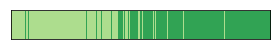

In [48]:
from metrics import barcode_plot
barcode_plot(scores, both_correct)

# BBOX IOU vs Mahal Distance

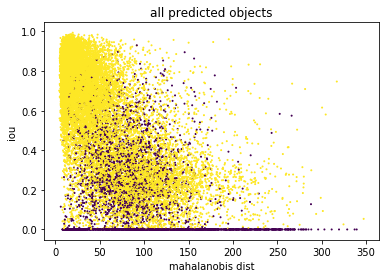

In [49]:
with open("gt_bboxes_test.pickle", "rb") as f:
    gt_bboxes= pickle.load(f)
with open("gt_labels_test.pickle", "rb") as f:
    gt_labels = pickle.load(f)
with open("gt_difficults_test.pickle", "rb") as f:
    gt_difficults = pickle.load(f)

with open("pred_bboxes_test.pickle", "rb") as f:
    pred_bboxes = pickle.load(f)
with open("pred_labels_test.pickle", "rb") as f:
    pred_labels = pickle.load(f)
with open("pred_scores_test.pickle", "rb") as f:
    pred_scores = pickle.load(f)

# Loop through results by image
bboxes_err = list()
correct_classification = list()

for ii, (gt_bbox, gt_label, pred_bbox, pred_label, pred_score) \
            in enumerate(zip(gt_bboxes, gt_labels, pred_bboxes, pred_labels, pred_scores)):
    # Calculate if the pred bbox has an overlapping gt_bbox
    bboxes_err.append([])
    correct_classification.append([])
    for bbox, label, score in zip(pred_bbox, pred_label, pred_score):
        bbox_err, correct_class = iou(bbox, label, gt_bbox, gt_label)
        bboxes_err[-1].append(bbox_err)
        correct_classification[-1].append(correct_class)

pred_scores_ = list(chain(*pred_scores))
bboxes_err_ = list(chain(*bboxes_err))
class_correct_ = list(chain(*correct_classification))
both_correct_ = [e > IOU_THRESH and c for e, c in zip(bboxes_err_, class_correct_)]

fig = plt.figure()
plt.scatter(pred_scores_, bboxes_err_, c=class_correct_, s=1)
plt.title("all predicted objects")
plt.xlabel("mahalanobis dist")
plt.ylabel("iou")
plt.show()

# BBOX IOU vs Max Softmax

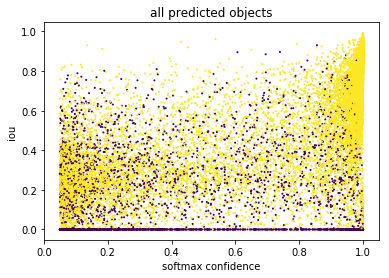

In [50]:
with open("gt_bboxes_test_softmax.pickle", "rb") as f:
    gt_bboxes = pickle.load(f)
with open("gt_labels_test_softmax.pickle", "rb") as f:
    gt_labels = pickle.load(f)
with open("gt_difficults_test_softmax.pickle", "rb") as f:
    gt_difficults = pickle.load(f)

with open("pred_bboxes_test_softmax.pickle", "rb") as f:
    pred_bboxes = pickle.load(f)
with open("pred_labels_test_softmax.pickle", "rb") as f:
    pred_labels = pickle.load(f)
with open("pred_scores_test_softmax.pickle", "rb") as f:
    pred_scores = pickle.load(f)

# Loop through results by image
bboxes_err = list()
correct_classification = list()

for ii, (gt_bbox, gt_label, pred_bbox, pred_label, pred_score) \
            in enumerate(zip(gt_bboxes, gt_labels, pred_bboxes, pred_labels, pred_scores)):
    # Calculate if the pred bbox has an overlapping gt_bbox
    bboxes_err.append([])
    correct_classification.append([])
    for bbox, label, score in zip(pred_bbox, pred_label, pred_score):
        bbox_err, correct_class = iou(bbox, label, gt_bbox, gt_label)
        bboxes_err[-1].append(bbox_err)
        correct_classification[-1].append(correct_class)

pred_scores_ = list(chain(*pred_scores))
bboxes_err_ = list(chain(*bboxes_err))
class_correct_ = list(chain(*correct_classification))
both_correct_ = [e > IOU_THRESH and c for e, c in zip(bboxes_err_, class_correct_)]

fig = plt.figure()
plt.scatter(pred_scores_, bboxes_err_, c=class_correct_, s=1)
plt.title("all predicted objects")
plt.xlabel("softmax confidence")
plt.ylabel("iou")
plt.show()

# AUROC on class correct, bbox incorrect

## Mahalanobis

In [51]:
with open("gt_bboxes_test.pickle", "rb") as f:
    gt_bboxes= pickle.load(f)
with open("gt_labels_test.pickle", "rb") as f:
    gt_labels = pickle.load(f)
with open("gt_difficults_test.pickle", "rb") as f:
    gt_difficults = pickle.load(f)

with open("pred_bboxes_test.pickle", "rb") as f:
    pred_bboxes = pickle.load(f)
with open("pred_labels_test.pickle", "rb") as f:
    pred_labels = pickle.load(f)
with open("pred_scores_test.pickle", "rb") as f:
    pred_scores = pickle.load(f)

In [52]:
# Loop through results by image
overlapping_bboxes = list()
correct_classification = list()

for ii, (gt_bbox, gt_label, pred_bbox, pred_label, pred_score) \
            in enumerate(zip(gt_bboxes, gt_labels, pred_bboxes, pred_labels, pred_scores)):
    # Calculate if the pred bbox has an overlapping gt_bbox
    overlapping_bboxes.append([])
    correct_classification.append([])
    for bbox, label, score in zip(pred_bbox, pred_label, pred_score):
        overlapping_bbox, correct_class = iou(bbox, label, gt_bbox, gt_label)
        overlapping_bboxes[-1].append(overlapping_bbox >= IOU_THRESH)
        correct_classification[-1].append(correct_class)

In [53]:
scores = [-1 * s for s in chain(*pred_scores)]
overlap_correct = list(chain(*overlapping_bboxes))
class_correct = list(chain(*correct_classification))
just_overlap_incorrect = [(not a) and b for a, b in zip(overlap_correct, class_correct)]

print("AUROC")
print(auroc(scores, just_overlap_incorrect))
print()
print("FPR@95TPR")
print(fpr_at_95_tpr(scores, just_overlap_incorrect))
print()
print("Detection Err")
print(detection_error(scores, just_overlap_incorrect))

AUROC
0.20845610206555343

FPR@95TPR
0.9767550911039657

Detection Err
0.513228788114111


## Max Softmax

In [54]:
with open("gt_bboxes_test_softmax.pickle", "rb") as f:
    gt_bboxes = pickle.load(f)
with open("gt_labels_test_softmax.pickle", "rb") as f:
    gt_labels = pickle.load(f)
with open("gt_difficults_test_softmax.pickle", "rb") as f:
    gt_difficults = pickle.load(f)

with open("pred_bboxes_test_softmax.pickle", "rb") as f:
    pred_bboxes = pickle.load(f)
with open("pred_labels_test_softmax.pickle", "rb") as f:
    pred_labels = pickle.load(f)
with open("pred_scores_test_softmax.pickle", "rb") as f:
    pred_scores = pickle.load(f)

In [55]:
# Loop through results by image
overlapping_bboxes = list()
correct_classification = list()

for ii, (gt_bbox, gt_label, pred_bbox, pred_label, pred_score) \
            in enumerate(zip(gt_bboxes, gt_labels, pred_bboxes, pred_labels, pred_scores)):
    # Calculate if the pred bbox has an overlapping gt_bbox
    overlapping_bboxes.append([])
    correct_classification.append([])
    for bbox, label, score in zip(pred_bbox, pred_label, pred_score):
        overlapping_bbox, correct_class = iou(bbox, label, gt_bbox, gt_label)
        overlapping_bboxes[-1].append(overlapping_bbox > IOU_THRESH)
        correct_classification[-1].append(correct_class)

In [56]:
scores = [-1 * s for s in chain(*pred_scores)]
overlap_correct = list(chain(*overlapping_bboxes))
class_correct = list(chain(*correct_classification))
just_overlap_incorrect = [(not a) and b for a, b in zip(overlap_correct, class_correct)]

print("AUROC")
print(auroc(scores, just_overlap_incorrect))
print()
print("FPR@95TPR")
print(fpr_at_95_tpr(scores, just_overlap_incorrect))
print()
print("Detection Err")
print(detection_error(scores, just_overlap_incorrect))

AUROC
0.8252040021950187

FPR@95TPR
0.42510718113612006

Detection Err
0.23740483313018815


# Catching object detections over background

### Mahalanobis

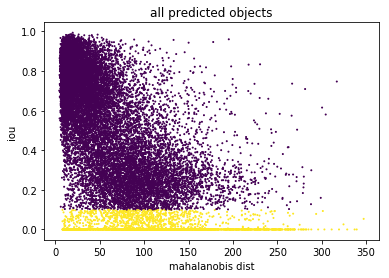

In [57]:
with open("gt_bboxes_test.pickle", "rb") as f:
    gt_bboxes= pickle.load(f)
with open("gt_labels_test.pickle", "rb") as f:
    gt_labels = pickle.load(f)
with open("gt_difficults_test.pickle", "rb") as f:
    gt_difficults = pickle.load(f)

with open("pred_bboxes_test.pickle", "rb") as f:
    pred_bboxes = pickle.load(f)
with open("pred_labels_test.pickle", "rb") as f:
    pred_labels = pickle.load(f)
with open("pred_scores_test.pickle", "rb") as f:
    pred_scores = pickle.load(f)

# Loop through results by image
bboxes_err = list()
correct_classification = list()

for ii, (gt_bbox, gt_label, pred_bbox, pred_label, pred_score) \
            in enumerate(zip(gt_bboxes, gt_labels, pred_bboxes, pred_labels, pred_scores)):
    # Calculate if the pred bbox has an overlapping gt_bbox
    bboxes_err.append([])
    correct_classification.append([])
    for bbox, label, score in zip(pred_bbox, pred_label, pred_score):
        bbox_err, correct_class = iou(bbox, label, gt_bbox, gt_label)
        bboxes_err[-1].append(bbox_err)
        correct_classification[-1].append(correct_class)

mahal_scores_ = list(chain(*pred_scores))
bboxes_err_ = list(chain(*bboxes_err))
class_correct_ = list(chain(*correct_classification))
both_correct_ = [e > IOU_THRESH and c for e, c in zip(bboxes_err_, class_correct_)]

fig = plt.figure()
plt.scatter(mahal_scores_, bboxes_err_, c=[e < 0.1 for e in bboxes_err_], s=1)
plt.title("all predicted objects")
plt.xlabel("mahalanobis dist")
plt.ylabel("iou")
plt.show()

### Max softmax

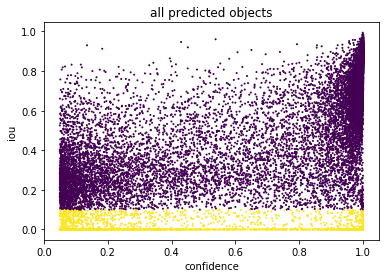

In [58]:
with open("gt_bboxes_test_softmax.pickle", "rb") as f:
    gt_bboxes = pickle.load(f)
with open("gt_labels_test_softmax.pickle", "rb") as f:
    gt_labels = pickle.load(f)
with open("gt_difficults_test_softmax.pickle", "rb") as f:
    gt_difficults = pickle.load(f)

with open("pred_bboxes_test_softmax.pickle", "rb") as f:
    pred_bboxes = pickle.load(f)
with open("pred_labels_test_softmax.pickle", "rb") as f:
    pred_labels = pickle.load(f)
with open("pred_scores_test_softmax.pickle", "rb") as f:
    pred_scores = pickle.load(f)

# Loop through results by image
bboxes_err = list()
correct_classification = list()

for ii, (gt_bbox, gt_label, pred_bbox, pred_label, pred_score) \
            in enumerate(zip(gt_bboxes, gt_labels, pred_bboxes, pred_labels, pred_scores)):
    # Calculate if the pred bbox has an overlapping gt_bbox
    bboxes_err.append([])
    correct_classification.append([])
    for bbox, label, score in zip(pred_bbox, pred_label, pred_score):
        bbox_err, correct_class = iou(bbox, label, gt_bbox, gt_label)
        bboxes_err[-1].append(bbox_err)
        correct_classification[-1].append(correct_class)

softmax_scores_ = list(chain(*pred_scores))
bboxes_err_ = list(chain(*bboxes_err))
class_correct_ = list(chain(*correct_classification))
both_correct_ = [e > IOU_THRESH and c for e, c in zip(bboxes_err_, class_correct_)]

fig = plt.figure()
plt.scatter(softmax_scores_, bboxes_err_, c=[e < 0.1 for e in bboxes_err_], s=1)
plt.title("all predicted objects")
plt.xlabel("confidence")
plt.ylabel("iou")
plt.show()

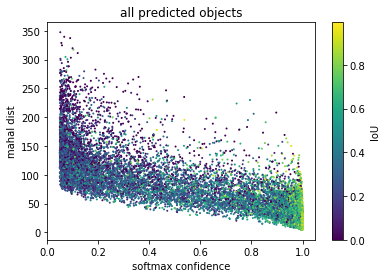

In [59]:
fig = plt.figure()
plt.scatter(softmax_scores_, mahal_scores_, c=bboxes_err_, s=1, cmap='viridis', label='predicted objs')

cbar = plt.colorbar()
cbar.set_label('IoU')

plt.title("all predicted objects")
plt.xlabel("softmax confidence")
plt.ylabel("mahal dist")
plt.show()

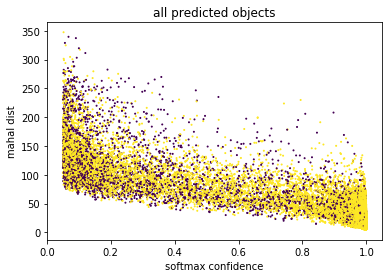

In [60]:
fig = plt.figure()
plt.scatter(softmax_scores_, mahal_scores_, c=class_correct_, s=1, cmap='viridis', label='predicted objs')

plt.title("all predicted objects")
plt.xlabel("softmax confidence")
plt.ylabel("mahal dist")
plt.show()

# Evaluate object detector

## Training data

In [61]:
from train import eval as eval_detector

dataset = TestDataset(opt, split='train')
dataloader = DataLoader(dataset,
                        batch_size=1,
                        shuffle=False,
                        pin_memory=True,
                        num_workers=opt.num_workers)

train_results = eval_detector(dataloader, trainer.faster_rcnn, test_num=3712)



  0%|          | 0/3712 [00:00<?, ?it/s]

  0%|          | 1/3712 [00:00<19:34,  3.16it/s]

  0%|          | 2/3712 [00:00<16:44,  3.69it/s]

  0%|          | 3/3712 [00:00<14:20,  4.31it/s]

  0%|          | 4/3712 [00:00<12:40,  4.88it/s]

  0%|          | 5/3712 [00:00<11:47,  5.24it/s]

  0%|          | 6/3712 [00:01<10:58,  5.63it/s]

  0%|          | 7/3712 [00:01<12:06,  5.10it/s]

  0%|          | 8/3712 [00:01<11:17,  5.46it/s]

  0%|          | 9/3712 [00:01<11:00,  5.61it/s]

  0%|          | 10/3712 [00:01<10:41,  5.77it/s]

  0%|          | 11/3712 [00:01<10:21,  5.96it/s]

  0%|          | 12/3712 [00:02<09:55,  6.21it/s]

  0%|          | 13/3712 [00:02<09:38,  6.39it/s]

  0%|          | 14/3712 [00:02<09:38,  6.40it/s]

  0%|          | 15/3712 [00:02<09:52,  6.24it/s]

  0%|          | 16/3712 [00:02<10:08,  6.08it/s]

  0%|          | 17/3712 [00:02<10:03,  6.12it/s]

  0%|          | 18/3712 [00:03<09:53,  6.22it/s]

  1%|          | 19/3712 [00:03<09:37,  6.40it/

  4%|▍         | 143/3712 [00:23<08:56,  6.65it/s]

  4%|▍         | 144/3712 [00:23<08:47,  6.76it/s]

  4%|▍         | 145/3712 [00:23<08:45,  6.79it/s]

  4%|▍         | 146/3712 [00:23<08:45,  6.79it/s]

  4%|▍         | 147/3712 [00:24<08:43,  6.81it/s]

  4%|▍         | 148/3712 [00:24<08:45,  6.79it/s]

  4%|▍         | 149/3712 [00:24<08:44,  6.80it/s]

  4%|▍         | 150/3712 [00:24<08:51,  6.70it/s]

  4%|▍         | 151/3712 [00:24<08:50,  6.72it/s]

  4%|▍         | 152/3712 [00:24<08:59,  6.60it/s]

  4%|▍         | 153/3712 [00:25<08:52,  6.69it/s]

  4%|▍         | 154/3712 [00:25<08:55,  6.64it/s]

  4%|▍         | 155/3712 [00:25<09:00,  6.58it/s]

  4%|▍         | 156/3712 [00:25<09:02,  6.55it/s]

  4%|▍         | 157/3712 [00:25<09:08,  6.48it/s]

  4%|▍         | 158/3712 [00:25<09:04,  6.53it/s]

  4%|▍         | 159/3712 [00:25<09:16,  6.38it/s]

  4%|▍         | 160/3712 [00:26<09:13,  6.42it/s]

  4%|▍         | 161/3712 [00:26<09:16,  6.38it/s]

  4%|▍      

  8%|▊         | 284/3712 [00:45<08:24,  6.80it/s]

  8%|▊         | 285/3712 [00:45<08:20,  6.84it/s]

  8%|▊         | 286/3712 [00:46<08:31,  6.70it/s]

  8%|▊         | 287/3712 [00:46<08:31,  6.70it/s]

  8%|▊         | 288/3712 [00:46<08:33,  6.67it/s]

  8%|▊         | 289/3712 [00:46<08:30,  6.70it/s]

  8%|▊         | 290/3712 [00:46<08:34,  6.65it/s]

  8%|▊         | 291/3712 [00:46<08:33,  6.66it/s]

  8%|▊         | 292/3712 [00:47<08:38,  6.60it/s]

  8%|▊         | 293/3712 [00:47<08:32,  6.67it/s]

  8%|▊         | 294/3712 [00:47<08:34,  6.64it/s]

  8%|▊         | 295/3712 [00:47<08:40,  6.57it/s]

  8%|▊         | 296/3712 [00:47<08:33,  6.65it/s]

  8%|▊         | 297/3712 [00:47<08:29,  6.70it/s]

  8%|▊         | 298/3712 [00:47<08:25,  6.75it/s]

  8%|▊         | 299/3712 [00:48<08:27,  6.72it/s]

  8%|▊         | 300/3712 [00:48<08:29,  6.70it/s]

  8%|▊         | 301/3712 [00:48<08:31,  6.66it/s]

  8%|▊         | 302/3712 [00:48<08:34,  6.63it/s]

  8%|▊      

 11%|█▏        | 425/3712 [01:07<08:38,  6.34it/s]

 11%|█▏        | 426/3712 [01:07<08:31,  6.42it/s]

 12%|█▏        | 427/3712 [01:07<08:31,  6.42it/s]

 12%|█▏        | 428/3712 [01:08<08:27,  6.47it/s]

 12%|█▏        | 429/3712 [01:08<08:34,  6.38it/s]

 12%|█▏        | 430/3712 [01:08<08:30,  6.43it/s]

 12%|█▏        | 431/3712 [01:08<08:35,  6.37it/s]

 12%|█▏        | 432/3712 [01:08<10:33,  5.18it/s]

 12%|█▏        | 433/3712 [01:08<09:53,  5.52it/s]

 12%|█▏        | 434/3712 [01:09<09:26,  5.79it/s]

 12%|█▏        | 435/3712 [01:09<09:16,  5.89it/s]

 12%|█▏        | 436/3712 [01:09<08:48,  6.19it/s]

 12%|█▏        | 437/3712 [01:09<08:52,  6.15it/s]

 12%|█▏        | 438/3712 [01:09<08:43,  6.25it/s]

 12%|█▏        | 439/3712 [01:09<08:35,  6.35it/s]

 12%|█▏        | 440/3712 [01:09<08:29,  6.42it/s]

 12%|█▏        | 441/3712 [01:10<08:42,  6.26it/s]

 12%|█▏        | 442/3712 [01:10<08:36,  6.34it/s]

 12%|█▏        | 443/3712 [01:10<08:29,  6.41it/s]

 12%|█▏     

 15%|█▌        | 566/3712 [01:29<07:57,  6.58it/s]

 15%|█▌        | 567/3712 [01:29<08:12,  6.39it/s]

 15%|█▌        | 568/3712 [01:29<08:02,  6.51it/s]

 15%|█▌        | 569/3712 [01:30<10:39,  4.92it/s]

 15%|█▌        | 570/3712 [01:30<09:49,  5.33it/s]

 15%|█▌        | 571/3712 [01:30<09:14,  5.66it/s]

 15%|█▌        | 572/3712 [01:30<08:47,  5.95it/s]

 15%|█▌        | 573/3712 [01:30<08:30,  6.15it/s]

 15%|█▌        | 574/3712 [01:30<08:18,  6.30it/s]

 15%|█▌        | 575/3712 [01:31<08:10,  6.39it/s]

 16%|█▌        | 576/3712 [01:31<08:01,  6.52it/s]

 16%|█▌        | 577/3712 [01:31<08:00,  6.53it/s]

 16%|█▌        | 578/3712 [01:31<07:58,  6.55it/s]

 16%|█▌        | 579/3712 [01:31<07:54,  6.61it/s]

 16%|█▌        | 580/3712 [01:31<07:56,  6.58it/s]

 16%|█▌        | 581/3712 [01:32<07:51,  6.64it/s]

 16%|█▌        | 582/3712 [01:32<07:46,  6.72it/s]

 16%|█▌        | 583/3712 [01:32<07:43,  6.75it/s]

 16%|█▌        | 584/3712 [01:32<07:44,  6.74it/s]

 16%|█▌     

 19%|█▉        | 707/3712 [01:51<07:27,  6.71it/s]

 19%|█▉        | 708/3712 [01:51<07:26,  6.72it/s]

 19%|█▉        | 709/3712 [01:52<07:32,  6.64it/s]

 19%|█▉        | 710/3712 [01:52<07:33,  6.63it/s]

 19%|█▉        | 711/3712 [01:52<07:34,  6.60it/s]

 19%|█▉        | 712/3712 [01:52<07:34,  6.61it/s]

 19%|█▉        | 713/3712 [01:52<07:30,  6.66it/s]

 19%|█▉        | 714/3712 [01:52<08:25,  5.93it/s]

 19%|█▉        | 715/3712 [01:52<08:10,  6.10it/s]

 19%|█▉        | 716/3712 [01:53<08:22,  5.96it/s]

 19%|█▉        | 717/3712 [01:53<08:25,  5.92it/s]

 19%|█▉        | 718/3712 [01:53<08:11,  6.09it/s]

 19%|█▉        | 719/3712 [01:53<10:36,  4.70it/s]

 19%|█▉        | 720/3712 [01:53<09:38,  5.18it/s]

 19%|█▉        | 721/3712 [01:54<08:52,  5.62it/s]

 19%|█▉        | 722/3712 [01:54<08:20,  5.97it/s]

 19%|█▉        | 723/3712 [01:54<08:03,  6.19it/s]

 20%|█▉        | 724/3712 [01:54<07:50,  6.36it/s]

 20%|█▉        | 725/3712 [01:54<07:43,  6.44it/s]

 20%|█▉     

 23%|██▎       | 848/3712 [02:14<07:39,  6.24it/s]

 23%|██▎       | 849/3712 [02:14<08:03,  5.92it/s]

 23%|██▎       | 850/3712 [02:14<08:04,  5.90it/s]

 23%|██▎       | 851/3712 [02:14<07:56,  6.01it/s]

 23%|██▎       | 852/3712 [02:14<07:47,  6.12it/s]

 23%|██▎       | 853/3712 [02:15<07:47,  6.12it/s]

 23%|██▎       | 854/3712 [02:15<07:38,  6.24it/s]

 23%|██▎       | 855/3712 [02:15<07:37,  6.24it/s]

 23%|██▎       | 856/3712 [02:15<07:26,  6.40it/s]

 23%|██▎       | 857/3712 [02:15<07:20,  6.48it/s]

 23%|██▎       | 858/3712 [02:15<07:21,  6.46it/s]

 23%|██▎       | 859/3712 [02:16<07:20,  6.48it/s]

 23%|██▎       | 860/3712 [02:16<07:32,  6.30it/s]

 23%|██▎       | 861/3712 [02:16<07:43,  6.16it/s]

 23%|██▎       | 862/3712 [02:16<08:24,  5.64it/s]

 23%|██▎       | 863/3712 [02:16<08:04,  5.87it/s]

 23%|██▎       | 864/3712 [02:16<07:48,  6.07it/s]

 23%|██▎       | 865/3712 [02:17<07:44,  6.13it/s]

 23%|██▎       | 866/3712 [02:17<07:32,  6.29it/s]

 23%|██▎    

 27%|██▋       | 989/3712 [02:36<06:55,  6.55it/s]

 27%|██▋       | 990/3712 [02:36<06:49,  6.64it/s]

 27%|██▋       | 991/3712 [02:36<06:54,  6.56it/s]

 27%|██▋       | 992/3712 [02:37<07:06,  6.38it/s]

 27%|██▋       | 993/3712 [02:37<06:53,  6.57it/s]

 27%|██▋       | 994/3712 [02:37<06:57,  6.52it/s]

 27%|██▋       | 995/3712 [02:37<06:56,  6.52it/s]

 27%|██▋       | 996/3712 [02:37<06:58,  6.48it/s]

 27%|██▋       | 997/3712 [02:37<06:56,  6.52it/s]

 27%|██▋       | 998/3712 [02:38<06:56,  6.51it/s]

 27%|██▋       | 999/3712 [02:38<06:50,  6.61it/s]

 27%|██▋       | 1000/3712 [02:38<06:44,  6.70it/s]

 27%|██▋       | 1001/3712 [02:38<06:55,  6.53it/s]

 27%|██▋       | 1002/3712 [02:38<06:51,  6.59it/s]

 27%|██▋       | 1003/3712 [02:38<06:50,  6.59it/s]

 27%|██▋       | 1004/3712 [02:38<06:46,  6.66it/s]

 27%|██▋       | 1005/3712 [02:39<07:25,  6.07it/s]

 27%|██▋       | 1006/3712 [02:39<07:20,  6.14it/s]

 27%|██▋       | 1007/3712 [02:39<07:11,  6.26it/s]

 27%

 30%|███       | 1128/3712 [02:58<06:49,  6.30it/s]

 30%|███       | 1129/3712 [02:58<06:54,  6.24it/s]

 30%|███       | 1130/3712 [02:59<06:50,  6.29it/s]

 30%|███       | 1131/3712 [02:59<06:55,  6.22it/s]

 30%|███       | 1132/3712 [02:59<06:51,  6.27it/s]

 31%|███       | 1133/3712 [02:59<06:42,  6.40it/s]

 31%|███       | 1134/3712 [02:59<07:51,  5.47it/s]

 31%|███       | 1135/3712 [02:59<07:24,  5.80it/s]

 31%|███       | 1136/3712 [03:00<07:01,  6.11it/s]

 31%|███       | 1137/3712 [03:00<07:04,  6.06it/s]

 31%|███       | 1138/3712 [03:00<06:55,  6.19it/s]

 31%|███       | 1139/3712 [03:00<08:53,  4.82it/s]

 31%|███       | 1140/3712 [03:00<08:42,  4.93it/s]

 31%|███       | 1141/3712 [03:01<08:06,  5.29it/s]

 31%|███       | 1142/3712 [03:01<07:36,  5.64it/s]

 31%|███       | 1143/3712 [03:01<07:19,  5.85it/s]

 31%|███       | 1144/3712 [03:01<07:19,  5.84it/s]

 31%|███       | 1145/3712 [03:01<07:12,  5.93it/s]

 31%|███       | 1146/3712 [03:01<06:57,  6.15

 34%|███▍      | 1266/3712 [03:20<06:07,  6.66it/s]

 34%|███▍      | 1267/3712 [03:20<06:08,  6.64it/s]

 34%|███▍      | 1268/3712 [03:20<06:08,  6.63it/s]

 34%|███▍      | 1269/3712 [03:20<06:11,  6.57it/s]

 34%|███▍      | 1270/3712 [03:21<06:06,  6.67it/s]

 34%|███▍      | 1271/3712 [03:21<05:59,  6.78it/s]

 34%|███▍      | 1272/3712 [03:21<06:05,  6.68it/s]

 34%|███▍      | 1273/3712 [03:21<06:05,  6.68it/s]

 34%|███▍      | 1274/3712 [03:21<05:59,  6.79it/s]

 34%|███▍      | 1275/3712 [03:21<06:03,  6.70it/s]

 34%|███▍      | 1276/3712 [03:21<06:01,  6.75it/s]

 34%|███▍      | 1277/3712 [03:22<06:04,  6.68it/s]

 34%|███▍      | 1278/3712 [03:22<06:02,  6.71it/s]

 34%|███▍      | 1279/3712 [03:22<06:01,  6.74it/s]

 34%|███▍      | 1280/3712 [03:22<06:05,  6.66it/s]

 35%|███▍      | 1281/3712 [03:22<06:03,  6.68it/s]

 35%|███▍      | 1282/3712 [03:22<06:01,  6.73it/s]

 35%|███▍      | 1283/3712 [03:23<06:03,  6.68it/s]

 35%|███▍      | 1284/3712 [03:23<05:58,  6.77

 38%|███▊      | 1404/3712 [03:42<05:51,  6.57it/s]

 38%|███▊      | 1405/3712 [03:42<05:50,  6.57it/s]

 38%|███▊      | 1406/3712 [03:42<05:48,  6.62it/s]

 38%|███▊      | 1407/3712 [03:42<05:44,  6.69it/s]

 38%|███▊      | 1408/3712 [03:42<05:41,  6.74it/s]

 38%|███▊      | 1409/3712 [03:43<05:50,  6.57it/s]

 38%|███▊      | 1410/3712 [03:43<05:44,  6.68it/s]

 38%|███▊      | 1411/3712 [03:43<05:40,  6.76it/s]

 38%|███▊      | 1412/3712 [03:43<05:38,  6.79it/s]

 38%|███▊      | 1413/3712 [03:43<05:35,  6.86it/s]

 38%|███▊      | 1414/3712 [03:43<05:38,  6.78it/s]

 38%|███▊      | 1415/3712 [03:43<05:40,  6.75it/s]

 38%|███▊      | 1416/3712 [03:44<05:39,  6.76it/s]

 38%|███▊      | 1417/3712 [03:44<05:40,  6.73it/s]

 38%|███▊      | 1418/3712 [03:44<05:45,  6.64it/s]

 38%|███▊      | 1419/3712 [03:44<05:49,  6.57it/s]

 38%|███▊      | 1420/3712 [03:44<05:48,  6.58it/s]

 38%|███▊      | 1421/3712 [03:44<05:46,  6.61it/s]

 38%|███▊      | 1422/3712 [03:45<05:44,  6.65

 42%|████▏     | 1542/3712 [04:03<05:20,  6.77it/s]

 42%|████▏     | 1543/3712 [04:04<05:20,  6.76it/s]

 42%|████▏     | 1544/3712 [04:04<05:27,  6.63it/s]

 42%|████▏     | 1545/3712 [04:04<05:24,  6.68it/s]

 42%|████▏     | 1546/3712 [04:04<05:21,  6.73it/s]

 42%|████▏     | 1547/3712 [04:04<05:22,  6.70it/s]

 42%|████▏     | 1548/3712 [04:04<05:18,  6.80it/s]

 42%|████▏     | 1549/3712 [04:04<05:21,  6.74it/s]

 42%|████▏     | 1550/3712 [04:05<05:21,  6.72it/s]

 42%|████▏     | 1551/3712 [04:05<05:21,  6.72it/s]

 42%|████▏     | 1552/3712 [04:05<05:20,  6.73it/s]

 42%|████▏     | 1553/3712 [04:05<05:47,  6.20it/s]

 42%|████▏     | 1554/3712 [04:05<05:50,  6.15it/s]

 42%|████▏     | 1555/3712 [04:05<05:44,  6.27it/s]

 42%|████▏     | 1556/3712 [04:06<05:31,  6.50it/s]

 42%|████▏     | 1557/3712 [04:06<05:26,  6.61it/s]

 42%|████▏     | 1558/3712 [04:06<05:39,  6.34it/s]

 42%|████▏     | 1559/3712 [04:06<05:40,  6.33it/s]

 42%|████▏     | 1560/3712 [04:06<05:30,  6.52

 45%|████▌     | 1680/3712 [04:25<05:12,  6.49it/s]

 45%|████▌     | 1681/3712 [04:25<05:13,  6.48it/s]

 45%|████▌     | 1682/3712 [04:25<05:09,  6.55it/s]

 45%|████▌     | 1683/3712 [04:25<05:06,  6.61it/s]

 45%|████▌     | 1684/3712 [04:25<05:08,  6.57it/s]

 45%|████▌     | 1685/3712 [04:26<05:07,  6.58it/s]

 45%|████▌     | 1686/3712 [04:26<05:11,  6.51it/s]

 45%|████▌     | 1687/3712 [04:26<05:15,  6.42it/s]

 45%|████▌     | 1688/3712 [04:26<05:17,  6.37it/s]

 46%|████▌     | 1689/3712 [04:26<05:15,  6.41it/s]

 46%|████▌     | 1690/3712 [04:26<05:14,  6.43it/s]

 46%|████▌     | 1691/3712 [04:27<05:14,  6.42it/s]

 46%|████▌     | 1692/3712 [04:27<05:10,  6.50it/s]

 46%|████▌     | 1693/3712 [04:27<05:07,  6.57it/s]

 46%|████▌     | 1694/3712 [04:27<05:11,  6.48it/s]

 46%|████▌     | 1695/3712 [04:27<05:10,  6.50it/s]

 46%|████▌     | 1696/3712 [04:27<05:09,  6.51it/s]

 46%|████▌     | 1697/3712 [04:27<05:05,  6.60it/s]

 46%|████▌     | 1698/3712 [04:28<05:01,  6.69

 49%|████▉     | 1818/3712 [04:46<05:04,  6.23it/s]

 49%|████▉     | 1819/3712 [04:46<04:55,  6.42it/s]

 49%|████▉     | 1820/3712 [04:46<04:52,  6.47it/s]

 49%|████▉     | 1821/3712 [04:47<04:52,  6.47it/s]

 49%|████▉     | 1822/3712 [04:47<04:47,  6.58it/s]

 49%|████▉     | 1823/3712 [04:47<04:44,  6.64it/s]

 49%|████▉     | 1824/3712 [04:47<04:47,  6.58it/s]

 49%|████▉     | 1825/3712 [04:47<04:45,  6.62it/s]

 49%|████▉     | 1826/3712 [04:47<04:42,  6.68it/s]

 49%|████▉     | 1827/3712 [04:47<04:45,  6.61it/s]

 49%|████▉     | 1828/3712 [04:48<04:45,  6.60it/s]

 49%|████▉     | 1829/3712 [04:48<04:44,  6.61it/s]

 49%|████▉     | 1830/3712 [04:48<04:45,  6.58it/s]

 49%|████▉     | 1831/3712 [04:48<04:45,  6.60it/s]

 49%|████▉     | 1832/3712 [04:48<04:44,  6.60it/s]

 49%|████▉     | 1833/3712 [04:48<04:45,  6.58it/s]

 49%|████▉     | 1834/3712 [04:49<04:46,  6.55it/s]

 49%|████▉     | 1835/3712 [04:49<04:47,  6.52it/s]

 49%|████▉     | 1836/3712 [04:49<04:43,  6.61

 53%|█████▎    | 1956/3712 [05:07<04:19,  6.76it/s]

 53%|█████▎    | 1957/3712 [05:07<04:23,  6.66it/s]

 53%|█████▎    | 1958/3712 [05:07<04:22,  6.69it/s]

 53%|█████▎    | 1959/3712 [05:08<04:29,  6.49it/s]

 53%|█████▎    | 1960/3712 [05:08<04:27,  6.54it/s]

 53%|█████▎    | 1961/3712 [05:08<07:03,  4.14it/s]

 53%|█████▎    | 1962/3712 [05:08<06:15,  4.66it/s]

 53%|█████▎    | 1963/3712 [05:08<05:40,  5.13it/s]

 53%|█████▎    | 1964/3712 [05:09<05:16,  5.53it/s]

 53%|█████▎    | 1965/3712 [05:09<05:01,  5.80it/s]

 53%|█████▎    | 1966/3712 [05:09<05:04,  5.74it/s]

 53%|█████▎    | 1967/3712 [05:09<04:55,  5.90it/s]

 53%|█████▎    | 1968/3712 [05:09<04:46,  6.09it/s]

 53%|█████▎    | 1969/3712 [05:09<04:40,  6.22it/s]

 53%|█████▎    | 1970/3712 [05:10<04:33,  6.37it/s]

 53%|█████▎    | 1971/3712 [05:10<04:27,  6.51it/s]

 53%|█████▎    | 1972/3712 [05:10<04:28,  6.48it/s]

 53%|█████▎    | 1973/3712 [05:10<04:25,  6.54it/s]

 53%|█████▎    | 1974/3712 [05:10<04:21,  6.66

 56%|█████▋    | 2094/3712 [05:29<04:17,  6.29it/s]

 56%|█████▋    | 2095/3712 [05:29<04:15,  6.34it/s]

 56%|█████▋    | 2096/3712 [05:30<04:11,  6.42it/s]

 56%|█████▋    | 2097/3712 [05:30<04:08,  6.50it/s]

 57%|█████▋    | 2098/3712 [05:30<04:01,  6.70it/s]

 57%|█████▋    | 2099/3712 [05:30<04:01,  6.68it/s]

 57%|█████▋    | 2100/3712 [05:30<04:03,  6.61it/s]

 57%|█████▋    | 2101/3712 [05:30<04:04,  6.59it/s]

 57%|█████▋    | 2102/3712 [05:30<03:57,  6.78it/s]

 57%|█████▋    | 2103/3712 [05:31<03:57,  6.79it/s]

 57%|█████▋    | 2104/3712 [05:31<04:00,  6.68it/s]

 57%|█████▋    | 2105/3712 [05:31<03:59,  6.72it/s]

 57%|█████▋    | 2106/3712 [05:31<04:00,  6.67it/s]

 57%|█████▋    | 2107/3712 [05:31<04:02,  6.61it/s]

 57%|█████▋    | 2108/3712 [05:31<03:57,  6.75it/s]

 57%|█████▋    | 2109/3712 [05:31<03:59,  6.69it/s]

 57%|█████▋    | 2110/3712 [05:32<03:59,  6.68it/s]

 57%|█████▋    | 2111/3712 [05:32<04:00,  6.65it/s]

 57%|█████▋    | 2112/3712 [05:32<04:01,  6.63

 60%|██████    | 2232/3712 [05:51<03:40,  6.71it/s]

 60%|██████    | 2233/3712 [05:51<03:43,  6.63it/s]

 60%|██████    | 2234/3712 [05:51<03:42,  6.64it/s]

 60%|██████    | 2235/3712 [05:51<03:45,  6.55it/s]

 60%|██████    | 2236/3712 [05:52<03:44,  6.58it/s]

 60%|██████    | 2237/3712 [05:52<03:44,  6.57it/s]

 60%|██████    | 2238/3712 [05:52<03:45,  6.54it/s]

 60%|██████    | 2239/3712 [05:52<04:10,  5.88it/s]

 60%|██████    | 2240/3712 [05:52<04:11,  5.85it/s]

 60%|██████    | 2241/3712 [05:53<05:01,  4.88it/s]

 60%|██████    | 2242/3712 [05:53<04:38,  5.27it/s]

 60%|██████    | 2243/3712 [05:53<04:21,  5.62it/s]

 60%|██████    | 2244/3712 [05:53<04:10,  5.85it/s]

 60%|██████    | 2245/3712 [05:53<04:01,  6.06it/s]

 61%|██████    | 2246/3712 [05:53<03:58,  6.14it/s]

 61%|██████    | 2247/3712 [05:53<03:56,  6.20it/s]

 61%|██████    | 2248/3712 [05:54<03:53,  6.28it/s]

 61%|██████    | 2249/3712 [05:54<03:48,  6.40it/s]

 61%|██████    | 2250/3712 [05:54<03:50,  6.35

 64%|██████▍   | 2370/3712 [06:14<03:24,  6.57it/s]

 64%|██████▍   | 2371/3712 [06:14<03:25,  6.53it/s]

 64%|██████▍   | 2372/3712 [06:14<04:31,  4.94it/s]

 64%|██████▍   | 2373/3712 [06:14<04:07,  5.42it/s]

 64%|██████▍   | 2374/3712 [06:15<03:59,  5.59it/s]

 64%|██████▍   | 2375/3712 [06:15<03:48,  5.85it/s]

 64%|██████▍   | 2376/3712 [06:15<03:39,  6.08it/s]

 64%|██████▍   | 2377/3712 [06:15<03:32,  6.28it/s]

 64%|██████▍   | 2378/3712 [06:15<03:30,  6.33it/s]

 64%|██████▍   | 2379/3712 [06:15<03:29,  6.38it/s]

 64%|██████▍   | 2380/3712 [06:15<03:31,  6.31it/s]

 64%|██████▍   | 2381/3712 [06:16<03:32,  6.28it/s]

 64%|██████▍   | 2382/3712 [06:16<03:32,  6.26it/s]

 64%|██████▍   | 2383/3712 [06:16<03:28,  6.38it/s]

 64%|██████▍   | 2384/3712 [06:16<03:34,  6.20it/s]

 64%|██████▍   | 2385/3712 [06:16<03:28,  6.37it/s]

 64%|██████▍   | 2386/3712 [06:16<03:29,  6.33it/s]

 64%|██████▍   | 2387/3712 [06:17<03:28,  6.36it/s]

 64%|██████▍   | 2388/3712 [06:17<03:24,  6.46

 68%|██████▊   | 2508/3712 [06:36<03:00,  6.67it/s]

 68%|██████▊   | 2509/3712 [06:36<03:01,  6.64it/s]

 68%|██████▊   | 2510/3712 [06:36<02:59,  6.71it/s]

 68%|██████▊   | 2511/3712 [06:36<03:18,  6.05it/s]

 68%|██████▊   | 2512/3712 [06:36<03:13,  6.19it/s]

 68%|██████▊   | 2513/3712 [06:36<03:10,  6.30it/s]

 68%|██████▊   | 2514/3712 [06:37<03:06,  6.42it/s]

 68%|██████▊   | 2515/3712 [06:37<03:09,  6.31it/s]

 68%|██████▊   | 2516/3712 [06:37<03:05,  6.44it/s]

 68%|██████▊   | 2517/3712 [06:37<03:02,  6.55it/s]

 68%|██████▊   | 2518/3712 [06:37<03:01,  6.56it/s]

 68%|██████▊   | 2519/3712 [06:37<03:00,  6.60it/s]

 68%|██████▊   | 2520/3712 [06:38<03:01,  6.56it/s]

 68%|██████▊   | 2521/3712 [06:38<03:00,  6.60it/s]

 68%|██████▊   | 2522/3712 [06:38<03:05,  6.43it/s]

 68%|██████▊   | 2523/3712 [06:38<03:05,  6.40it/s]

 68%|██████▊   | 2524/3712 [06:38<03:25,  5.79it/s]

 68%|██████▊   | 2525/3712 [06:38<03:18,  5.98it/s]

 68%|██████▊   | 2526/3712 [06:39<03:10,  6.24

 71%|███████▏  | 2646/3712 [06:58<03:32,  5.01it/s]

 71%|███████▏  | 2647/3712 [06:59<03:40,  4.84it/s]

 71%|███████▏  | 2648/3712 [06:59<03:37,  4.88it/s]

 71%|███████▏  | 2649/3712 [06:59<03:30,  5.06it/s]

 71%|███████▏  | 2650/3712 [06:59<03:18,  5.35it/s]

 71%|███████▏  | 2651/3712 [06:59<03:23,  5.23it/s]

 71%|███████▏  | 2652/3712 [06:59<03:15,  5.41it/s]

 71%|███████▏  | 2653/3712 [07:00<03:17,  5.37it/s]

 71%|███████▏  | 2654/3712 [07:00<03:17,  5.35it/s]

 72%|███████▏  | 2655/3712 [07:00<03:14,  5.44it/s]

 72%|███████▏  | 2656/3712 [07:00<03:24,  5.16it/s]

 72%|███████▏  | 2657/3712 [07:00<03:35,  4.90it/s]

 72%|███████▏  | 2658/3712 [07:01<03:33,  4.93it/s]

 72%|███████▏  | 2659/3712 [07:01<03:38,  4.82it/s]

 72%|███████▏  | 2660/3712 [07:01<03:20,  5.24it/s]

 72%|███████▏  | 2661/3712 [07:01<03:09,  5.55it/s]

 72%|███████▏  | 2662/3712 [07:01<03:00,  5.81it/s]

 72%|███████▏  | 2663/3712 [07:01<02:53,  6.06it/s]

 72%|███████▏  | 2664/3712 [07:02<02:47,  6.26

 75%|███████▌  | 2784/3712 [07:21<02:46,  5.58it/s]

 75%|███████▌  | 2785/3712 [07:21<02:43,  5.67it/s]

 75%|███████▌  | 2786/3712 [07:21<02:39,  5.82it/s]

 75%|███████▌  | 2787/3712 [07:21<02:33,  6.03it/s]

 75%|███████▌  | 2788/3712 [07:21<02:32,  6.06it/s]

 75%|███████▌  | 2789/3712 [07:21<02:27,  6.24it/s]

 75%|███████▌  | 2790/3712 [07:22<02:24,  6.36it/s]

 75%|███████▌  | 2791/3712 [07:22<02:53,  5.30it/s]

 75%|███████▌  | 2792/3712 [07:22<02:41,  5.69it/s]

 75%|███████▌  | 2793/3712 [07:22<02:37,  5.83it/s]

 75%|███████▌  | 2794/3712 [07:22<02:32,  6.04it/s]

 75%|███████▌  | 2795/3712 [07:23<02:46,  5.51it/s]

 75%|███████▌  | 2796/3712 [07:23<02:35,  5.89it/s]

 75%|███████▌  | 2797/3712 [07:23<02:33,  5.96it/s]

 75%|███████▌  | 2798/3712 [07:23<02:27,  6.21it/s]

 75%|███████▌  | 2799/3712 [07:23<02:28,  6.13it/s]

 75%|███████▌  | 2800/3712 [07:23<02:26,  6.24it/s]

 75%|███████▌  | 2801/3712 [07:23<02:24,  6.29it/s]

 75%|███████▌  | 2802/3712 [07:24<02:20,  6.49

 79%|███████▊  | 2922/3712 [07:43<02:02,  6.43it/s]

 79%|███████▊  | 2923/3712 [07:43<02:03,  6.38it/s]

 79%|███████▉  | 2924/3712 [07:43<02:00,  6.52it/s]

 79%|███████▉  | 2925/3712 [07:43<01:58,  6.64it/s]

 79%|███████▉  | 2926/3712 [07:43<01:56,  6.77it/s]

 79%|███████▉  | 2927/3712 [07:43<01:55,  6.80it/s]

 79%|███████▉  | 2928/3712 [07:44<01:54,  6.86it/s]

 79%|███████▉  | 2929/3712 [07:44<02:13,  5.87it/s]

 79%|███████▉  | 2930/3712 [07:44<03:15,  3.99it/s]

 79%|███████▉  | 2931/3712 [07:44<02:51,  4.55it/s]

 79%|███████▉  | 2932/3712 [07:45<02:33,  5.07it/s]

 79%|███████▉  | 2933/3712 [07:45<02:22,  5.45it/s]

 79%|███████▉  | 2934/3712 [07:45<02:12,  5.86it/s]

 79%|███████▉  | 2935/3712 [07:45<02:07,  6.07it/s]

 79%|███████▉  | 2936/3712 [07:45<02:03,  6.27it/s]

 79%|███████▉  | 2937/3712 [07:45<02:02,  6.32it/s]

 79%|███████▉  | 2938/3712 [07:45<02:01,  6.37it/s]

 79%|███████▉  | 2939/3712 [07:46<01:58,  6.53it/s]

 79%|███████▉  | 2940/3712 [07:46<01:57,  6.59

 82%|████████▏ | 3060/3712 [08:04<01:38,  6.62it/s]

 82%|████████▏ | 3061/3712 [08:05<01:38,  6.60it/s]

 82%|████████▏ | 3062/3712 [08:05<01:37,  6.69it/s]

 83%|████████▎ | 3063/3712 [08:05<01:34,  6.83it/s]

 83%|████████▎ | 3064/3712 [08:05<01:34,  6.86it/s]

 83%|████████▎ | 3065/3712 [08:05<01:34,  6.81it/s]

 83%|████████▎ | 3066/3712 [08:05<01:35,  6.77it/s]

 83%|████████▎ | 3067/3712 [08:05<01:35,  6.74it/s]

 83%|████████▎ | 3068/3712 [08:06<01:35,  6.73it/s]

 83%|████████▎ | 3069/3712 [08:06<01:36,  6.65it/s]

 83%|████████▎ | 3070/3712 [08:06<01:36,  6.67it/s]

 83%|████████▎ | 3071/3712 [08:06<01:37,  6.59it/s]

 83%|████████▎ | 3072/3712 [08:06<01:36,  6.61it/s]

 83%|████████▎ | 3073/3712 [08:06<01:36,  6.64it/s]

 83%|████████▎ | 3074/3712 [08:07<01:36,  6.58it/s]

 83%|████████▎ | 3075/3712 [08:07<01:36,  6.60it/s]

 83%|████████▎ | 3076/3712 [08:07<01:35,  6.65it/s]

 83%|████████▎ | 3077/3712 [08:07<01:35,  6.66it/s]

 83%|████████▎ | 3078/3712 [08:07<01:34,  6.70

 86%|████████▌ | 3198/3712 [08:26<01:17,  6.60it/s]

 86%|████████▌ | 3199/3712 [08:26<01:18,  6.50it/s]

 86%|████████▌ | 3200/3712 [08:27<01:18,  6.53it/s]

 86%|████████▌ | 3201/3712 [08:27<01:17,  6.61it/s]

 86%|████████▋ | 3202/3712 [08:27<01:15,  6.73it/s]

 86%|████████▋ | 3203/3712 [08:27<01:15,  6.72it/s]

 86%|████████▋ | 3204/3712 [08:27<01:15,  6.76it/s]

 86%|████████▋ | 3205/3712 [08:27<01:14,  6.76it/s]

 86%|████████▋ | 3206/3712 [08:28<01:16,  6.59it/s]

 86%|████████▋ | 3207/3712 [08:28<01:17,  6.56it/s]

 86%|████████▋ | 3208/3712 [08:28<01:15,  6.66it/s]

 86%|████████▋ | 3209/3712 [08:28<01:16,  6.60it/s]

 86%|████████▋ | 3210/3712 [08:28<01:15,  6.63it/s]

 87%|████████▋ | 3211/3712 [08:28<01:16,  6.54it/s]

 87%|████████▋ | 3212/3712 [08:28<01:16,  6.50it/s]

 87%|████████▋ | 3213/3712 [08:29<01:16,  6.54it/s]

 87%|████████▋ | 3214/3712 [08:29<01:17,  6.46it/s]

 87%|████████▋ | 3215/3712 [08:29<01:20,  6.16it/s]

 87%|████████▋ | 3216/3712 [08:29<01:17,  6.39

 90%|████████▉ | 3336/3712 [08:48<01:01,  6.15it/s]

 90%|████████▉ | 3337/3712 [08:48<00:58,  6.39it/s]

 90%|████████▉ | 3338/3712 [08:49<00:58,  6.45it/s]

 90%|████████▉ | 3339/3712 [08:49<01:00,  6.16it/s]

 90%|████████▉ | 3340/3712 [08:49<00:59,  6.24it/s]

 90%|█████████ | 3341/3712 [08:49<00:57,  6.45it/s]

 90%|█████████ | 3342/3712 [08:49<00:57,  6.41it/s]

 90%|█████████ | 3343/3712 [08:49<00:55,  6.60it/s]

 90%|█████████ | 3344/3712 [08:49<00:55,  6.58it/s]

 90%|█████████ | 3345/3712 [08:50<01:02,  5.84it/s]

 90%|█████████ | 3346/3712 [08:50<01:01,  5.99it/s]

 90%|█████████ | 3347/3712 [08:50<00:59,  6.17it/s]

 90%|█████████ | 3348/3712 [08:50<00:57,  6.31it/s]

 90%|█████████ | 3349/3712 [08:50<00:57,  6.26it/s]

 90%|█████████ | 3350/3712 [08:50<00:55,  6.47it/s]

 90%|█████████ | 3351/3712 [08:51<00:55,  6.47it/s]

 90%|█████████ | 3352/3712 [08:51<00:56,  6.43it/s]

 90%|█████████ | 3353/3712 [08:51<00:56,  6.40it/s]

 90%|█████████ | 3354/3712 [08:51<00:54,  6.55

In [62]:
train_results

{'ap': array([0.80247249]), 'map': 0.8024724918855118}

## Validation data

In [63]:
from train import eval as eval_detector

test_dataset = TestDataset(opt)
test_dataloader = DataLoader(test_dataset,
                             batch_size=1,
                             shuffle=False,
                             pin_memory=True,
                             num_workers=opt.num_workers)

validation_result = eval_detector(test_dataloader, trainer.faster_rcnn, test_num=3768)



  0%|          | 0/3768 [00:00<?, ?it/s]

  0%|          | 1/3768 [00:00<10:16,  6.11it/s]

  0%|          | 2/3768 [00:00<10:06,  6.21it/s]

  0%|          | 3/3768 [00:00<10:36,  5.91it/s]

  0%|          | 4/3768 [00:00<12:10,  5.15it/s]

  0%|          | 5/3768 [00:00<12:30,  5.01it/s]

  0%|          | 6/3768 [00:01<11:52,  5.28it/s]

  0%|          | 7/3768 [00:01<11:21,  5.52it/s]

  0%|          | 8/3768 [00:01<10:51,  5.77it/s]

  0%|          | 9/3768 [00:01<10:24,  6.02it/s]

  0%|          | 10/3768 [00:01<10:15,  6.10it/s]

  0%|          | 11/3768 [00:01<10:00,  6.26it/s]

  0%|          | 12/3768 [00:02<10:12,  6.13it/s]

  0%|          | 13/3768 [00:02<10:38,  5.88it/s]

  0%|          | 14/3768 [00:02<10:22,  6.03it/s]

  0%|          | 15/3768 [00:02<09:55,  6.30it/s]

  0%|          | 16/3768 [00:02<09:41,  6.45it/s]

  0%|          | 17/3768 [00:02<09:37,  6.49it/s]

  0%|          | 18/3768 [00:03<09:38,  6.48it/s]

  1%|          | 19/3768 [00:03<09:31,  6.56it/

  4%|▍         | 143/3768 [00:23<09:07,  6.62it/s]

  4%|▍         | 144/3768 [00:23<09:03,  6.67it/s]

  4%|▍         | 145/3768 [00:24<09:05,  6.64it/s]

  4%|▍         | 146/3768 [00:24<09:05,  6.65it/s]

  4%|▍         | 147/3768 [00:24<08:58,  6.73it/s]

  4%|▍         | 148/3768 [00:24<09:03,  6.66it/s]

  4%|▍         | 149/3768 [00:24<09:01,  6.69it/s]

  4%|▍         | 150/3768 [00:24<08:55,  6.75it/s]

  4%|▍         | 151/3768 [00:24<08:58,  6.72it/s]

  4%|▍         | 152/3768 [00:25<09:00,  6.69it/s]

  4%|▍         | 153/3768 [00:25<09:02,  6.67it/s]

  4%|▍         | 154/3768 [00:25<08:52,  6.79it/s]

  4%|▍         | 155/3768 [00:25<09:02,  6.66it/s]

  4%|▍         | 156/3768 [00:25<09:25,  6.39it/s]

  4%|▍         | 157/3768 [00:26<12:29,  4.82it/s]

  4%|▍         | 158/3768 [00:26<11:34,  5.20it/s]

  4%|▍         | 159/3768 [00:26<10:42,  5.62it/s]

  4%|▍         | 160/3768 [00:26<10:04,  5.97it/s]

  4%|▍         | 161/3768 [00:26<09:42,  6.20it/s]

  4%|▍      

  8%|▊         | 284/3768 [00:46<08:36,  6.74it/s]

  8%|▊         | 285/3768 [00:46<08:41,  6.67it/s]

  8%|▊         | 286/3768 [00:46<08:55,  6.51it/s]

  8%|▊         | 287/3768 [00:46<08:48,  6.59it/s]

  8%|▊         | 288/3768 [00:46<08:39,  6.70it/s]

  8%|▊         | 289/3768 [00:47<08:36,  6.73it/s]

  8%|▊         | 290/3768 [00:47<08:30,  6.81it/s]

  8%|▊         | 291/3768 [00:47<08:31,  6.80it/s]

  8%|▊         | 292/3768 [00:47<08:30,  6.81it/s]

  8%|▊         | 293/3768 [00:47<08:29,  6.82it/s]

  8%|▊         | 294/3768 [00:47<08:42,  6.64it/s]

  8%|▊         | 295/3768 [00:47<09:09,  6.32it/s]

  8%|▊         | 296/3768 [00:48<09:01,  6.41it/s]

  8%|▊         | 297/3768 [00:48<08:48,  6.57it/s]

  8%|▊         | 298/3768 [00:48<08:39,  6.68it/s]

  8%|▊         | 299/3768 [00:48<08:41,  6.65it/s]

  8%|▊         | 300/3768 [00:48<08:42,  6.63it/s]

  8%|▊         | 301/3768 [00:48<08:42,  6.64it/s]

  8%|▊         | 302/3768 [00:48<08:41,  6.64it/s]

  8%|▊      

 11%|█▏        | 425/3768 [01:08<09:01,  6.17it/s]

 11%|█▏        | 426/3768 [01:08<08:50,  6.30it/s]

 11%|█▏        | 427/3768 [01:08<08:40,  6.41it/s]

 11%|█▏        | 428/3768 [01:08<08:36,  6.47it/s]

 11%|█▏        | 429/3768 [01:08<08:31,  6.53it/s]

 11%|█▏        | 430/3768 [01:09<08:33,  6.50it/s]

 11%|█▏        | 431/3768 [01:09<08:27,  6.57it/s]

 11%|█▏        | 432/3768 [01:09<08:29,  6.55it/s]

 11%|█▏        | 433/3768 [01:09<08:17,  6.70it/s]

 12%|█▏        | 434/3768 [01:09<08:13,  6.75it/s]

 12%|█▏        | 435/3768 [01:09<08:20,  6.66it/s]

 12%|█▏        | 436/3768 [01:09<08:17,  6.70it/s]

 12%|█▏        | 437/3768 [01:10<08:18,  6.68it/s]

 12%|█▏        | 438/3768 [01:10<08:31,  6.52it/s]

 12%|█▏        | 439/3768 [01:10<08:27,  6.56it/s]

 12%|█▏        | 440/3768 [01:10<08:27,  6.55it/s]

 12%|█▏        | 441/3768 [01:10<08:30,  6.52it/s]

 12%|█▏        | 442/3768 [01:10<08:20,  6.65it/s]

 12%|█▏        | 443/3768 [01:11<08:18,  6.68it/s]

 12%|█▏     

 15%|█▌        | 566/3768 [01:29<08:06,  6.58it/s]

 15%|█▌        | 567/3768 [01:29<08:01,  6.64it/s]

 15%|█▌        | 568/3768 [01:29<08:13,  6.48it/s]

 15%|█▌        | 569/3768 [01:30<07:59,  6.67it/s]

 15%|█▌        | 570/3768 [01:30<08:22,  6.36it/s]

 15%|█▌        | 571/3768 [01:30<08:15,  6.45it/s]

 15%|█▌        | 572/3768 [01:30<08:05,  6.58it/s]

 15%|█▌        | 573/3768 [01:30<08:02,  6.62it/s]

 15%|█▌        | 574/3768 [01:30<08:06,  6.56it/s]

 15%|█▌        | 575/3768 [01:30<08:01,  6.63it/s]

 15%|█▌        | 576/3768 [01:31<07:59,  6.65it/s]

 15%|█▌        | 577/3768 [01:31<07:57,  6.69it/s]

 15%|█▌        | 578/3768 [01:31<07:51,  6.76it/s]

 15%|█▌        | 579/3768 [01:31<07:51,  6.76it/s]

 15%|█▌        | 580/3768 [01:31<07:47,  6.83it/s]

 15%|█▌        | 581/3768 [01:31<07:47,  6.82it/s]

 15%|█▌        | 582/3768 [01:31<07:48,  6.80it/s]

 15%|█▌        | 583/3768 [01:32<07:46,  6.83it/s]

 15%|█▌        | 584/3768 [01:32<08:19,  6.38it/s]

 16%|█▌     

 19%|█▉        | 707/3768 [01:51<07:37,  6.69it/s]

 19%|█▉        | 708/3768 [01:52<07:39,  6.66it/s]

 19%|█▉        | 709/3768 [01:52<07:39,  6.65it/s]

 19%|█▉        | 710/3768 [01:52<07:35,  6.72it/s]

 19%|█▉        | 711/3768 [01:52<08:09,  6.25it/s]

 19%|█▉        | 712/3768 [01:52<07:55,  6.43it/s]

 19%|█▉        | 713/3768 [01:52<07:46,  6.56it/s]

 19%|█▉        | 714/3768 [01:52<07:40,  6.63it/s]

 19%|█▉        | 715/3768 [01:53<07:37,  6.68it/s]

 19%|█▉        | 716/3768 [01:53<07:33,  6.73it/s]

 19%|█▉        | 717/3768 [01:53<07:29,  6.79it/s]

 19%|█▉        | 718/3768 [01:53<08:18,  6.12it/s]

 19%|█▉        | 719/3768 [01:53<08:05,  6.28it/s]

 19%|█▉        | 720/3768 [01:53<08:06,  6.26it/s]

 19%|█▉        | 721/3768 [01:54<07:57,  6.38it/s]

 19%|█▉        | 722/3768 [01:54<08:02,  6.31it/s]

 19%|█▉        | 723/3768 [01:54<07:45,  6.54it/s]

 19%|█▉        | 724/3768 [01:54<07:47,  6.51it/s]

 19%|█▉        | 725/3768 [01:54<07:52,  6.44it/s]

 19%|█▉     

 23%|██▎       | 848/3768 [02:13<07:56,  6.12it/s]

 23%|██▎       | 849/3768 [02:14<07:43,  6.29it/s]

 23%|██▎       | 850/3768 [02:14<07:34,  6.43it/s]

 23%|██▎       | 851/3768 [02:14<07:45,  6.27it/s]

 23%|██▎       | 852/3768 [02:14<07:50,  6.19it/s]

 23%|██▎       | 853/3768 [02:14<07:41,  6.31it/s]

 23%|██▎       | 854/3768 [02:14<07:37,  6.37it/s]

 23%|██▎       | 855/3768 [02:15<09:57,  4.87it/s]

 23%|██▎       | 856/3768 [02:15<09:07,  5.32it/s]

 23%|██▎       | 857/3768 [02:15<08:33,  5.67it/s]

 23%|██▎       | 858/3768 [02:15<08:10,  5.93it/s]

 23%|██▎       | 859/3768 [02:15<07:53,  6.15it/s]

 23%|██▎       | 860/3768 [02:15<07:40,  6.32it/s]

 23%|██▎       | 861/3768 [02:16<07:32,  6.42it/s]

 23%|██▎       | 862/3768 [02:16<07:24,  6.53it/s]

 23%|██▎       | 863/3768 [02:16<07:18,  6.62it/s]

 23%|██▎       | 864/3768 [02:16<07:17,  6.64it/s]

 23%|██▎       | 865/3768 [02:16<07:14,  6.68it/s]

 23%|██▎       | 866/3768 [02:16<07:17,  6.63it/s]

 23%|██▎    

 26%|██▌       | 989/3768 [02:36<07:02,  6.58it/s]

 26%|██▋       | 990/3768 [02:36<07:00,  6.61it/s]

 26%|██▋       | 991/3768 [02:36<06:52,  6.73it/s]

 26%|██▋       | 992/3768 [02:36<06:59,  6.61it/s]

 26%|██▋       | 993/3768 [02:36<06:51,  6.74it/s]

 26%|██▋       | 994/3768 [02:37<06:53,  6.72it/s]

 26%|██▋       | 995/3768 [02:37<06:55,  6.67it/s]

 26%|██▋       | 996/3768 [02:37<06:51,  6.74it/s]

 26%|██▋       | 997/3768 [02:37<06:56,  6.65it/s]

 26%|██▋       | 998/3768 [02:37<07:02,  6.55it/s]

 27%|██▋       | 999/3768 [02:37<06:57,  6.63it/s]

 27%|██▋       | 1000/3768 [02:37<06:50,  6.75it/s]

 27%|██▋       | 1001/3768 [02:38<06:48,  6.77it/s]

 27%|██▋       | 1002/3768 [02:38<06:48,  6.77it/s]

 27%|██▋       | 1003/3768 [02:38<06:51,  6.73it/s]

 27%|██▋       | 1004/3768 [02:38<06:51,  6.71it/s]

 27%|██▋       | 1005/3768 [02:38<06:52,  6.70it/s]

 27%|██▋       | 1006/3768 [02:38<06:53,  6.67it/s]

 27%|██▋       | 1007/3768 [02:39<07:06,  6.47it/s]

 27%

 30%|██▉       | 1128/3768 [03:00<06:38,  6.62it/s]

 30%|██▉       | 1129/3768 [03:00<06:32,  6.72it/s]

 30%|██▉       | 1130/3768 [03:00<07:23,  5.95it/s]

 30%|███       | 1131/3768 [03:00<08:40,  5.06it/s]

 30%|███       | 1132/3768 [03:01<08:00,  5.49it/s]

 30%|███       | 1133/3768 [03:01<07:35,  5.78it/s]

 30%|███       | 1134/3768 [03:01<07:24,  5.93it/s]

 30%|███       | 1135/3768 [03:01<09:35,  4.58it/s]

 30%|███       | 1136/3768 [03:01<08:37,  5.08it/s]

 30%|███       | 1137/3768 [03:01<08:01,  5.46it/s]

 30%|███       | 1138/3768 [03:02<07:30,  5.84it/s]

 30%|███       | 1139/3768 [03:02<07:23,  5.93it/s]

 30%|███       | 1140/3768 [03:02<07:09,  6.12it/s]

 30%|███       | 1141/3768 [03:02<06:54,  6.33it/s]

 30%|███       | 1142/3768 [03:02<06:54,  6.34it/s]

 30%|███       | 1143/3768 [03:02<06:47,  6.45it/s]

 30%|███       | 1144/3768 [03:03<06:41,  6.53it/s]

 30%|███       | 1145/3768 [03:03<06:36,  6.61it/s]

 30%|███       | 1146/3768 [03:03<06:31,  6.70

 34%|███▎      | 1266/3768 [03:22<07:08,  5.83it/s]

 34%|███▎      | 1267/3768 [03:22<06:48,  6.12it/s]

 34%|███▎      | 1268/3768 [03:22<06:41,  6.22it/s]

 34%|███▎      | 1269/3768 [03:22<06:31,  6.38it/s]

 34%|███▎      | 1270/3768 [03:23<06:22,  6.54it/s]

 34%|███▎      | 1271/3768 [03:23<06:19,  6.58it/s]

 34%|███▍      | 1272/3768 [03:23<06:18,  6.60it/s]

 34%|███▍      | 1273/3768 [03:23<06:26,  6.46it/s]

 34%|███▍      | 1274/3768 [03:23<06:24,  6.48it/s]

 34%|███▍      | 1275/3768 [03:23<06:18,  6.59it/s]

 34%|███▍      | 1276/3768 [03:24<06:20,  6.55it/s]

 34%|███▍      | 1277/3768 [03:24<06:15,  6.63it/s]

 34%|███▍      | 1278/3768 [03:24<06:13,  6.67it/s]

 34%|███▍      | 1279/3768 [03:24<06:15,  6.63it/s]

 34%|███▍      | 1280/3768 [03:24<06:14,  6.64it/s]

 34%|███▍      | 1281/3768 [03:24<06:08,  6.75it/s]

 34%|███▍      | 1282/3768 [03:24<06:12,  6.67it/s]

 34%|███▍      | 1283/3768 [03:25<06:12,  6.67it/s]

 34%|███▍      | 1284/3768 [03:25<06:22,  6.50

 37%|███▋      | 1404/3768 [03:44<06:04,  6.48it/s]

 37%|███▋      | 1405/3768 [03:44<05:59,  6.58it/s]

 37%|███▋      | 1406/3768 [03:44<05:55,  6.65it/s]

 37%|███▋      | 1407/3768 [03:44<05:49,  6.75it/s]

 37%|███▋      | 1408/3768 [03:45<05:55,  6.64it/s]

 37%|███▋      | 1409/3768 [03:45<05:53,  6.68it/s]

 37%|███▋      | 1410/3768 [03:45<05:48,  6.76it/s]

 37%|███▋      | 1411/3768 [03:45<05:45,  6.81it/s]

 37%|███▋      | 1412/3768 [03:45<05:56,  6.60it/s]

 38%|███▊      | 1413/3768 [03:45<05:52,  6.69it/s]

 38%|███▊      | 1414/3768 [03:46<05:52,  6.68it/s]

 38%|███▊      | 1415/3768 [03:46<05:47,  6.77it/s]

 38%|███▊      | 1416/3768 [03:46<05:48,  6.75it/s]

 38%|███▊      | 1417/3768 [03:46<05:49,  6.73it/s]

 38%|███▊      | 1418/3768 [03:46<05:48,  6.74it/s]

 38%|███▊      | 1419/3768 [03:46<05:47,  6.76it/s]

 38%|███▊      | 1420/3768 [03:46<05:50,  6.69it/s]

 38%|███▊      | 1421/3768 [03:47<05:52,  6.66it/s]

 38%|███▊      | 1422/3768 [03:47<05:46,  6.76

 41%|████      | 1542/3768 [04:06<05:47,  6.40it/s]

 41%|████      | 1543/3768 [04:06<06:15,  5.93it/s]

 41%|████      | 1544/3768 [04:06<05:54,  6.28it/s]

 41%|████      | 1545/3768 [04:06<06:04,  6.10it/s]

 41%|████      | 1546/3768 [04:06<07:45,  4.77it/s]

 41%|████      | 1547/3768 [04:07<07:18,  5.07it/s]

 41%|████      | 1548/3768 [04:07<06:52,  5.38it/s]

 41%|████      | 1549/3768 [04:07<06:34,  5.62it/s]

 41%|████      | 1550/3768 [04:07<06:19,  5.84it/s]

 41%|████      | 1551/3768 [04:07<06:11,  5.97it/s]

 41%|████      | 1552/3768 [04:07<06:02,  6.11it/s]

 41%|████      | 1553/3768 [04:07<05:51,  6.30it/s]

 41%|████      | 1554/3768 [04:08<05:53,  6.26it/s]

 41%|████▏     | 1555/3768 [04:08<05:49,  6.33it/s]

 41%|████▏     | 1556/3768 [04:08<05:53,  6.27it/s]

 41%|████▏     | 1557/3768 [04:08<05:59,  6.15it/s]

 41%|████▏     | 1558/3768 [04:08<06:00,  6.14it/s]

 41%|████▏     | 1559/3768 [04:08<05:59,  6.14it/s]

 41%|████▏     | 1560/3768 [04:09<05:58,  6.15

 45%|████▍     | 1680/3768 [04:29<05:34,  6.25it/s]

 45%|████▍     | 1681/3768 [04:29<05:37,  6.18it/s]

 45%|████▍     | 1682/3768 [04:30<05:42,  6.10it/s]

 45%|████▍     | 1683/3768 [04:30<05:50,  5.95it/s]

 45%|████▍     | 1684/3768 [04:30<05:49,  5.97it/s]

 45%|████▍     | 1685/3768 [04:30<05:57,  5.82it/s]

 45%|████▍     | 1686/3768 [04:30<07:35,  4.57it/s]

 45%|████▍     | 1687/3768 [04:31<07:16,  4.77it/s]

 45%|████▍     | 1688/3768 [04:31<07:08,  4.85it/s]

 45%|████▍     | 1689/3768 [04:31<06:36,  5.24it/s]

 45%|████▍     | 1690/3768 [04:31<06:13,  5.56it/s]

 45%|████▍     | 1691/3768 [04:31<06:03,  5.71it/s]

 45%|████▍     | 1692/3768 [04:32<06:08,  5.64it/s]

 45%|████▍     | 1693/3768 [04:32<06:50,  5.05it/s]

 45%|████▍     | 1694/3768 [04:32<06:26,  5.36it/s]

 45%|████▍     | 1695/3768 [04:32<05:57,  5.80it/s]

 45%|████▌     | 1696/3768 [04:32<05:49,  5.93it/s]

 45%|████▌     | 1697/3768 [04:32<05:42,  6.05it/s]

 45%|████▌     | 1698/3768 [04:33<05:39,  6.09

 48%|████▊     | 1818/3768 [04:53<05:11,  6.26it/s]

 48%|████▊     | 1819/3768 [04:53<05:14,  6.19it/s]

 48%|████▊     | 1820/3768 [04:53<05:06,  6.35it/s]

 48%|████▊     | 1821/3768 [04:53<05:06,  6.34it/s]

 48%|████▊     | 1822/3768 [04:53<05:04,  6.40it/s]

 48%|████▊     | 1823/3768 [04:53<05:01,  6.44it/s]

 48%|████▊     | 1824/3768 [04:54<06:26,  5.03it/s]

 48%|████▊     | 1825/3768 [04:54<06:01,  5.38it/s]

 48%|████▊     | 1826/3768 [04:54<05:43,  5.65it/s]

 48%|████▊     | 1827/3768 [04:54<05:59,  5.41it/s]

 49%|████▊     | 1828/3768 [04:54<05:38,  5.74it/s]

 49%|████▊     | 1829/3768 [04:55<07:04,  4.57it/s]

 49%|████▊     | 1830/3768 [04:55<06:28,  4.99it/s]

 49%|████▊     | 1831/3768 [04:55<06:09,  5.24it/s]

 49%|████▊     | 1832/3768 [04:55<05:51,  5.51it/s]

 49%|████▊     | 1833/3768 [04:55<05:31,  5.84it/s]

 49%|████▊     | 1834/3768 [04:55<05:19,  6.05it/s]

 49%|████▊     | 1835/3768 [04:56<05:11,  6.21it/s]

 49%|████▊     | 1836/3768 [04:56<05:11,  6.20

 52%|█████▏    | 1956/3768 [05:16<04:34,  6.61it/s]

 52%|█████▏    | 1957/3768 [05:16<04:46,  6.32it/s]

 52%|█████▏    | 1958/3768 [05:16<04:52,  6.19it/s]

 52%|█████▏    | 1959/3768 [05:16<04:47,  6.29it/s]

 52%|█████▏    | 1960/3768 [05:16<04:41,  6.43it/s]

 52%|█████▏    | 1961/3768 [05:16<04:44,  6.36it/s]

 52%|█████▏    | 1962/3768 [05:17<04:47,  6.27it/s]

 52%|█████▏    | 1963/3768 [05:17<04:43,  6.38it/s]

 52%|█████▏    | 1964/3768 [05:17<04:35,  6.55it/s]

 52%|█████▏    | 1965/3768 [05:17<04:32,  6.62it/s]

 52%|█████▏    | 1966/3768 [05:17<04:33,  6.59it/s]

 52%|█████▏    | 1967/3768 [05:17<04:28,  6.70it/s]

 52%|█████▏    | 1968/3768 [05:17<04:53,  6.14it/s]

 52%|█████▏    | 1969/3768 [05:18<04:41,  6.38it/s]

 52%|█████▏    | 1970/3768 [05:18<05:51,  5.12it/s]

 52%|█████▏    | 1971/3768 [05:18<05:22,  5.57it/s]

 52%|█████▏    | 1972/3768 [05:18<05:03,  5.92it/s]

 52%|█████▏    | 1973/3768 [05:18<06:11,  4.84it/s]

 52%|█████▏    | 1974/3768 [05:19<05:42,  5.24

 56%|█████▌    | 2094/3768 [05:38<04:13,  6.61it/s]

 56%|█████▌    | 2095/3768 [05:38<04:15,  6.55it/s]

 56%|█████▌    | 2096/3768 [05:38<04:23,  6.36it/s]

 56%|█████▌    | 2097/3768 [05:38<04:18,  6.46it/s]

 56%|█████▌    | 2098/3768 [05:38<04:16,  6.50it/s]

 56%|█████▌    | 2099/3768 [05:39<04:14,  6.55it/s]

 56%|█████▌    | 2100/3768 [05:39<04:12,  6.61it/s]

 56%|█████▌    | 2101/3768 [05:39<04:10,  6.66it/s]

 56%|█████▌    | 2102/3768 [05:39<04:10,  6.66it/s]

 56%|█████▌    | 2103/3768 [05:39<04:06,  6.76it/s]

 56%|█████▌    | 2104/3768 [05:39<04:12,  6.60it/s]

 56%|█████▌    | 2105/3768 [05:39<04:16,  6.48it/s]

 56%|█████▌    | 2106/3768 [05:40<04:15,  6.51it/s]

 56%|█████▌    | 2107/3768 [05:40<04:11,  6.60it/s]

 56%|█████▌    | 2108/3768 [05:40<04:08,  6.68it/s]

 56%|█████▌    | 2109/3768 [05:40<04:07,  6.69it/s]

 56%|█████▌    | 2110/3768 [05:40<04:08,  6.68it/s]

 56%|█████▌    | 2111/3768 [05:40<04:09,  6.64it/s]

 56%|█████▌    | 2112/3768 [05:40<04:06,  6.73

 59%|█████▉    | 2232/3768 [06:04<06:38,  3.85it/s]

 59%|█████▉    | 2233/3768 [06:04<06:17,  4.07it/s]

 59%|█████▉    | 2234/3768 [06:04<05:48,  4.40it/s]

 59%|█████▉    | 2235/3768 [06:04<05:25,  4.71it/s]

 59%|█████▉    | 2236/3768 [06:05<05:58,  4.28it/s]

 59%|█████▉    | 2237/3768 [06:05<06:12,  4.11it/s]

 59%|█████▉    | 2238/3768 [06:05<06:49,  3.74it/s]

 59%|█████▉    | 2239/3768 [06:06<08:13,  3.10it/s]

 59%|█████▉    | 2240/3768 [06:06<09:53,  2.57it/s]

 59%|█████▉    | 2241/3768 [06:07<10:14,  2.49it/s]

 60%|█████▉    | 2242/3768 [06:07<10:03,  2.53it/s]

 60%|█████▉    | 2243/3768 [06:07<09:59,  2.54it/s]

 60%|█████▉    | 2244/3768 [06:08<11:41,  2.17it/s]

 60%|█████▉    | 2245/3768 [06:09<13:02,  1.95it/s]

 60%|█████▉    | 2246/3768 [06:09<12:47,  1.98it/s]

 60%|█████▉    | 2247/3768 [06:09<10:32,  2.41it/s]

 60%|█████▉    | 2248/3768 [06:10<08:59,  2.81it/s]

 60%|█████▉    | 2249/3768 [06:11<13:06,  1.93it/s]

 60%|█████▉    | 2250/3768 [06:11<12:22,  2.04

 63%|██████▎   | 2370/3768 [06:36<03:45,  6.21it/s]

 63%|██████▎   | 2371/3768 [06:36<03:36,  6.44it/s]

 63%|██████▎   | 2372/3768 [06:36<03:35,  6.47it/s]

 63%|██████▎   | 2373/3768 [06:36<03:31,  6.58it/s]

 63%|██████▎   | 2374/3768 [06:37<03:30,  6.63it/s]

 63%|██████▎   | 2375/3768 [06:37<03:28,  6.68it/s]

 63%|██████▎   | 2376/3768 [06:37<03:29,  6.64it/s]

 63%|██████▎   | 2377/3768 [06:37<03:25,  6.77it/s]

 63%|██████▎   | 2378/3768 [06:37<03:27,  6.70it/s]

 63%|██████▎   | 2379/3768 [06:37<03:26,  6.74it/s]

 63%|██████▎   | 2380/3768 [06:37<03:32,  6.53it/s]

 63%|██████▎   | 2381/3768 [06:38<03:31,  6.55it/s]

 63%|██████▎   | 2382/3768 [06:38<03:30,  6.58it/s]

 63%|██████▎   | 2383/3768 [06:38<03:30,  6.58it/s]

 63%|██████▎   | 2384/3768 [06:38<03:28,  6.63it/s]

 63%|██████▎   | 2385/3768 [06:38<03:33,  6.46it/s]

 63%|██████▎   | 2386/3768 [06:38<03:31,  6.52it/s]

 63%|██████▎   | 2387/3768 [06:39<03:29,  6.59it/s]

 63%|██████▎   | 2388/3768 [06:39<03:28,  6.62

 67%|██████▋   | 2508/3768 [06:59<03:23,  6.20it/s]

 67%|██████▋   | 2509/3768 [06:59<03:19,  6.30it/s]

 67%|██████▋   | 2510/3768 [06:59<03:15,  6.43it/s]

 67%|██████▋   | 2511/3768 [06:59<03:12,  6.54it/s]

 67%|██████▋   | 2512/3768 [06:59<03:11,  6.55it/s]

 67%|██████▋   | 2513/3768 [06:59<03:16,  6.37it/s]

 67%|██████▋   | 2514/3768 [07:00<03:16,  6.39it/s]

 67%|██████▋   | 2515/3768 [07:00<03:15,  6.42it/s]

 67%|██████▋   | 2516/3768 [07:00<03:11,  6.53it/s]

 67%|██████▋   | 2517/3768 [07:00<03:09,  6.59it/s]

 67%|██████▋   | 2518/3768 [07:00<03:07,  6.68it/s]

 67%|██████▋   | 2519/3768 [07:00<03:06,  6.69it/s]

 67%|██████▋   | 2520/3768 [07:00<03:07,  6.66it/s]

 67%|██████▋   | 2521/3768 [07:01<03:08,  6.63it/s]

 67%|██████▋   | 2522/3768 [07:01<03:09,  6.57it/s]

 67%|██████▋   | 2523/3768 [07:01<03:08,  6.61it/s]

 67%|██████▋   | 2524/3768 [07:01<03:05,  6.72it/s]

 67%|██████▋   | 2525/3768 [07:01<03:03,  6.76it/s]

 67%|██████▋   | 2526/3768 [07:01<03:03,  6.75

 70%|███████   | 2646/3768 [07:20<02:47,  6.71it/s]

 70%|███████   | 2647/3768 [07:20<02:45,  6.77it/s]

 70%|███████   | 2648/3768 [07:20<02:53,  6.45it/s]

 70%|███████   | 2649/3768 [07:21<02:52,  6.48it/s]

 70%|███████   | 2650/3768 [07:21<02:50,  6.57it/s]

 70%|███████   | 2651/3768 [07:21<02:50,  6.57it/s]

 70%|███████   | 2652/3768 [07:21<02:57,  6.30it/s]

 70%|███████   | 2653/3768 [07:21<03:00,  6.19it/s]

 70%|███████   | 2654/3768 [07:21<03:09,  5.87it/s]

 70%|███████   | 2655/3768 [07:22<03:03,  6.05it/s]

 70%|███████   | 2656/3768 [07:22<02:59,  6.19it/s]

 71%|███████   | 2657/3768 [07:22<02:56,  6.31it/s]

 71%|███████   | 2658/3768 [07:22<03:02,  6.09it/s]

 71%|███████   | 2659/3768 [07:22<02:55,  6.30it/s]

 71%|███████   | 2660/3768 [07:22<02:55,  6.32it/s]

 71%|███████   | 2661/3768 [07:22<02:53,  6.39it/s]

 71%|███████   | 2662/3768 [07:23<03:00,  6.14it/s]

 71%|███████   | 2663/3768 [07:23<02:55,  6.30it/s]

 71%|███████   | 2664/3768 [07:23<02:55,  6.29

 74%|███████▍  | 2784/3768 [07:42<02:37,  6.24it/s]

 74%|███████▍  | 2785/3768 [07:42<02:32,  6.45it/s]

 74%|███████▍  | 2786/3768 [07:42<02:31,  6.48it/s]

 74%|███████▍  | 2787/3768 [07:42<02:29,  6.57it/s]

 74%|███████▍  | 2788/3768 [07:42<02:29,  6.54it/s]

 74%|███████▍  | 2789/3768 [07:42<02:30,  6.52it/s]

 74%|███████▍  | 2790/3768 [07:43<02:28,  6.58it/s]

 74%|███████▍  | 2791/3768 [07:43<02:28,  6.56it/s]

 74%|███████▍  | 2792/3768 [07:43<02:28,  6.59it/s]

 74%|███████▍  | 2793/3768 [07:43<02:26,  6.66it/s]

 74%|███████▍  | 2794/3768 [07:43<02:28,  6.57it/s]

 74%|███████▍  | 2795/3768 [07:43<02:25,  6.67it/s]

 74%|███████▍  | 2796/3768 [07:44<02:25,  6.68it/s]

 74%|███████▍  | 2797/3768 [07:44<02:24,  6.72it/s]

 74%|███████▍  | 2798/3768 [07:44<02:26,  6.61it/s]

 74%|███████▍  | 2799/3768 [07:44<02:24,  6.70it/s]

 74%|███████▍  | 2800/3768 [07:44<02:23,  6.74it/s]

 74%|███████▍  | 2801/3768 [07:44<02:22,  6.77it/s]

 74%|███████▍  | 2802/3768 [07:44<02:23,  6.75

 78%|███████▊  | 2922/3768 [08:04<02:06,  6.70it/s]

 78%|███████▊  | 2923/3768 [08:04<02:05,  6.72it/s]

 78%|███████▊  | 2924/3768 [08:04<02:06,  6.69it/s]

 78%|███████▊  | 2925/3768 [08:04<02:13,  6.29it/s]

 78%|███████▊  | 2926/3768 [08:05<02:10,  6.44it/s]

 78%|███████▊  | 2927/3768 [08:05<02:09,  6.48it/s]

 78%|███████▊  | 2928/3768 [08:05<02:10,  6.44it/s]

 78%|███████▊  | 2929/3768 [08:05<02:07,  6.58it/s]

 78%|███████▊  | 2930/3768 [08:05<02:07,  6.58it/s]

 78%|███████▊  | 2931/3768 [08:05<02:07,  6.55it/s]

 78%|███████▊  | 2932/3768 [08:06<02:05,  6.63it/s]

 78%|███████▊  | 2933/3768 [08:06<02:06,  6.60it/s]

 78%|███████▊  | 2934/3768 [08:06<02:04,  6.67it/s]

 78%|███████▊  | 2935/3768 [08:06<02:05,  6.65it/s]

 78%|███████▊  | 2936/3768 [08:06<02:05,  6.63it/s]

 78%|███████▊  | 2937/3768 [08:06<02:06,  6.55it/s]

 78%|███████▊  | 2938/3768 [08:06<02:06,  6.54it/s]

 78%|███████▊  | 2939/3768 [08:07<02:07,  6.48it/s]

 78%|███████▊  | 2940/3768 [08:07<02:07,  6.52

 81%|████████  | 3060/3768 [08:25<01:44,  6.77it/s]

 81%|████████  | 3061/3768 [08:26<01:44,  6.77it/s]

 81%|████████▏ | 3062/3768 [08:26<01:45,  6.72it/s]

 81%|████████▏ | 3063/3768 [08:26<01:45,  6.71it/s]

 81%|████████▏ | 3064/3768 [08:26<01:44,  6.71it/s]

 81%|████████▏ | 3065/3768 [08:26<01:45,  6.68it/s]

 81%|████████▏ | 3066/3768 [08:26<01:45,  6.68it/s]

 81%|████████▏ | 3067/3768 [08:27<01:46,  6.58it/s]

 81%|████████▏ | 3068/3768 [08:27<01:44,  6.70it/s]

 81%|████████▏ | 3069/3768 [08:27<01:46,  6.55it/s]

 81%|████████▏ | 3070/3768 [08:27<01:45,  6.59it/s]

 82%|████████▏ | 3071/3768 [08:27<01:45,  6.61it/s]

 82%|████████▏ | 3072/3768 [08:27<01:45,  6.58it/s]

 82%|████████▏ | 3073/3768 [08:27<01:45,  6.60it/s]

 82%|████████▏ | 3074/3768 [08:28<01:46,  6.50it/s]

 82%|████████▏ | 3075/3768 [08:28<01:46,  6.52it/s]

 82%|████████▏ | 3076/3768 [08:28<01:46,  6.53it/s]

 82%|████████▏ | 3077/3768 [08:28<01:45,  6.53it/s]

 82%|████████▏ | 3078/3768 [08:28<01:45,  6.57

 85%|████████▍ | 3198/3768 [08:48<01:25,  6.66it/s]

 85%|████████▍ | 3199/3768 [08:48<01:26,  6.58it/s]

 85%|████████▍ | 3200/3768 [08:48<01:25,  6.61it/s]

 85%|████████▍ | 3201/3768 [08:48<01:25,  6.60it/s]

 85%|████████▍ | 3202/3768 [08:49<01:25,  6.60it/s]

 85%|████████▌ | 3203/3768 [08:49<01:27,  6.47it/s]

 85%|████████▌ | 3204/3768 [08:49<01:26,  6.56it/s]

 85%|████████▌ | 3205/3768 [08:49<01:26,  6.54it/s]

 85%|████████▌ | 3206/3768 [08:49<01:25,  6.55it/s]

 85%|████████▌ | 3207/3768 [08:49<01:24,  6.65it/s]

 85%|████████▌ | 3208/3768 [08:49<01:28,  6.32it/s]

 85%|████████▌ | 3209/3768 [08:50<01:26,  6.49it/s]

 85%|████████▌ | 3210/3768 [08:50<01:25,  6.50it/s]

 85%|████████▌ | 3211/3768 [08:50<01:25,  6.53it/s]

 85%|████████▌ | 3212/3768 [08:50<01:24,  6.62it/s]

 85%|████████▌ | 3213/3768 [08:50<01:24,  6.58it/s]

 85%|████████▌ | 3214/3768 [08:50<01:23,  6.60it/s]

 85%|████████▌ | 3215/3768 [08:50<01:22,  6.69it/s]

 85%|████████▌ | 3216/3768 [08:51<01:23,  6.60

 89%|████████▊ | 3336/3768 [09:10<01:10,  6.12it/s]

 89%|████████▊ | 3337/3768 [09:10<01:09,  6.24it/s]

 89%|████████▊ | 3338/3768 [09:10<01:08,  6.25it/s]

 89%|████████▊ | 3339/3768 [09:10<01:08,  6.26it/s]

 89%|████████▊ | 3340/3768 [09:10<01:06,  6.40it/s]

 89%|████████▊ | 3341/3768 [09:10<01:05,  6.54it/s]

 89%|████████▊ | 3342/3768 [09:11<01:04,  6.59it/s]

 89%|████████▊ | 3343/3768 [09:11<01:04,  6.57it/s]

 89%|████████▊ | 3344/3768 [09:11<01:04,  6.60it/s]

 89%|████████▉ | 3345/3768 [09:11<01:03,  6.62it/s]

 89%|████████▉ | 3346/3768 [09:11<01:03,  6.67it/s]

 89%|████████▉ | 3347/3768 [09:11<01:02,  6.68it/s]

 89%|████████▉ | 3348/3768 [09:11<01:02,  6.74it/s]

 89%|████████▉ | 3349/3768 [09:12<01:02,  6.66it/s]

 89%|████████▉ | 3350/3768 [09:12<01:02,  6.66it/s]

 89%|████████▉ | 3351/3768 [09:12<01:04,  6.43it/s]

 89%|████████▉ | 3352/3768 [09:12<01:03,  6.52it/s]

 89%|████████▉ | 3353/3768 [09:12<01:03,  6.53it/s]

 89%|████████▉ | 3354/3768 [09:12<01:03,  6.52

 92%|█████████▏| 3474/3768 [09:31<00:43,  6.73it/s]

 92%|█████████▏| 3475/3768 [09:31<00:43,  6.68it/s]

 92%|█████████▏| 3476/3768 [09:32<00:43,  6.65it/s]

 92%|█████████▏| 3477/3768 [09:32<00:43,  6.64it/s]

 92%|█████████▏| 3478/3768 [09:32<00:43,  6.63it/s]

 92%|█████████▏| 3479/3768 [09:32<00:42,  6.73it/s]

 92%|█████████▏| 3480/3768 [09:32<00:42,  6.76it/s]

 92%|█████████▏| 3481/3768 [09:32<00:43,  6.67it/s]

 92%|█████████▏| 3482/3768 [09:32<00:46,  6.10it/s]

 92%|█████████▏| 3483/3768 [09:33<00:45,  6.32it/s]

 92%|█████████▏| 3484/3768 [09:33<00:44,  6.37it/s]

 92%|█████████▏| 3485/3768 [09:33<00:43,  6.47it/s]

 93%|█████████▎| 3486/3768 [09:33<00:42,  6.60it/s]

 93%|█████████▎| 3487/3768 [09:33<00:42,  6.63it/s]

 93%|█████████▎| 3488/3768 [09:33<00:42,  6.63it/s]

 93%|█████████▎| 3489/3768 [09:34<00:42,  6.56it/s]

 93%|█████████▎| 3490/3768 [09:34<00:43,  6.40it/s]

 93%|█████████▎| 3491/3768 [09:34<00:42,  6.45it/s]

 93%|█████████▎| 3492/3768 [09:34<00:47,  5.78

In [64]:
validation_result

{'ap': array([0.74622774]), 'map': 0.7462277363985176}